 <h1 style="color:blue;">  DATA 3550 Fall 2023 Final Project </h1>

## Imputation / EDA

### Import the required libraries

In [1]:
import numpy as np
import lightgbm as lgb
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
%matplotlib inline
import re
from xgboost import XGBClassifier
import datetime as dt
from datetime import timedelta
from scipy.stats import uniform
from sklearn.model_selection import RandomizedSearchCV
from sklearn.svm import SVC
from sklearn.metrics import mean_absolute_error
from sklearn import datasets, linear_model
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
lc = LabelEncoder()
import xgboost as xgb
import statsmodels
import statsmodels.api as sm
import statsmodels.formula.api as smf

from sklearn.model_selection import train_test_split, cross_val_score, RepeatedKFold, GridSearchCV
from sklearn.metrics import mean_squared_error,r2_score,mean_absolute_error,mean_absolute_percentage_error

from sklearn.pipeline import make_pipeline, Pipeline

from numpy import arange
from sklearn.linear_model import Lasso, Ridge
from sklearn.linear_model import LogisticRegression
from sklearn.kernel_ridge import KernelRidge


from sklearn import tree
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier, export_graphviz
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier, BaggingRegressor, RandomForestRegressor
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import ConfusionMatrixDisplay, accuracy_score
from sklearn.metrics import confusion_matrix, classification_report, precision_score, recall_score, roc_curve, roc_auc_score

# Trick to widen the screen
from IPython.core.display import display, HTML

#Widens the code landscape 
display(HTML("<style>.container { width:95% !important; }</style>"))

import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.max_columns',500)
pd.set_option('display.max_rows', 50)
sns.set_style('whitegrid')

C:\Users\Katabatic\AppData\Local\Temp\ipykernel_15080\40218631.py:44: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


### Read in the datasets and print the first five rows of each and use .info() to see how many rows, columns, missing values, and data types. I also ended up do ing most of my data imputation and removal of columns in this section due to the time constraint for EDA processing. 

In [2]:
df_TG = pd.read_csv('TheGeneral.csv', header = 0)
df_TG.head()

,AbilitecContactID,PolicyNumber,DriverNumber,AbilitecHouseholdID,DriverCount,ClaimCount,TotalPaid,ClaimNumber,AtFaultDescription,ClaimStatus,ClaimType,DateOfLoss,DriverID,LossState,PolicyStateCode,SubrogrationFlag,TermEffectiveDate,VehicleID,ClaimTransCount,ClaimTransPaidLoss,DaysToClaim,DaysToClaim_h
0,04ZJUS02EXPR09CB,Q080MDE1MTY2,1,04ZJUS0300X496LW,4,1,5086.61,PA0002364104,No fault,C,HAIL,2018-08-06 00:00:00,98,CO,CO,NO,2018-05-29 00:00:00,1,9.0,5086.61,0.0,0.0
1,04ZJUS0146KL4TTS,Q080MDEwOTEx,1,04ZJUS035SBF0GJ4,2,1,0.00,PA0002351705,Insured at fault,C,PG_IVREARENDCV,2018-05-24 00:00:00,1,CO,CO,NO,2018-05-24 00:00:00,1,4.0,0.00,0.0,0.0
2,04ZJUS02K2KC7DMW,Q080MDExOTIz,1,04ZJUS035ZXBZEH1,2,1,21397.74,PA0002344011,Insured at fault,C,PG_COLLISIONINTERSECTION,2018-06-17 00:00:00,1,CO,CO,NO,2018-05-25 00:00:00,1,53.0,21397.74,0.0,0.0
3,04ZJUS022XH2NVJ5,Q080MDIyMDcw,1,04ZJUS038P3W5KKR,5,3,0.00,PA0002348918,No fault,C,HAIL,2018-06-19 00:00:00,98,CO,CO,YES,2018-06-01 00:00:00,2,14.0,0.00,0.0,0.0
4,04ZJUS022XH2NVJ5,Q080MDIyMDcw,1,04ZJUS038P3W5KKR,5,3,0.00,PA0002348997,No fault,C,GLASSBREAKAGE,2018-06-30 00:00:00,1,CO,CO,NO,2018-06-01 00:00:00,2,1.0,0.00,0.0,0.0


In [3]:
df_TG.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11069 entries, 0 to 11068
Data columns (total 22 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   AbilitecContactID    11069 non-null  object 
 1   PolicyNumber         11069 non-null  object 
 2   DriverNumber         11069 non-null  int64  
 3   AbilitecHouseholdID  11069 non-null  object 
 4   DriverCount          11069 non-null  int64  
 5   ClaimCount           11069 non-null  int64  
 6   TotalPaid            11069 non-null  float64
 7   ClaimNumber          11069 non-null  object 
 8   AtFaultDescription   11069 non-null  object 
 9   ClaimStatus          11069 non-null  object 
 10  ClaimType            11069 non-null  object 
 11  DateOfLoss           11069 non-null  object 
 12  DriverID             11069 non-null  int64  
 13  LossState            11069 non-null  object 
 14  PolicyStateCode      10948 non-null  object 
 15  SubrogrationFlag     11069 non-null 

In [4]:
df_MQ = pd.read_csv('MasterQuote.csv', header = 0)
df_MQ.head()

,QuoteNumber,MQuotedTotalPayment,BiFcCoverageInd,CoverageTypeDescription,DriversActive,GaragingState,NamedInsuredMaritalStatus,PolicyNumber,PolicyStateCode,PolicyTerm,QuoteInitiatedTime,TermEffectiveDate,TermExpirationDate,AbilitecContactID,DriverNumber,AbilitecHouseholdID,DriverCount
0,MzM0MDA0OTE=,1136.0,BI NOFC,Liability Only,1,OR,Single,T1IyNzE0OTQ0,OR,12,2016-01-02 22:25:47,2016-01-02 00:00:00,2017-01-02 00:00:00,04ZJUS0220X4MKG7,1,04ZJUS033FV1YJP0,1
1,MzM0MDQxNzU=,0.0,NOBI NOFC,Liability Only,1,IL,Divorced,NaN,IL,12,2016-01-03 12:15:55,2016-01-03 00:00:00,2017-01-03 00:00:00,04ZJUS02W4N0B2J5,1,04ZJUS03543132P3,1
2,MzM0MTc2MTk=,1160.0,BI NOFC,Liability Only,2,NV,Married,TlYyNzE2MTE5,NV,12,2016-01-04 11:10:58,2016-01-04 00:00:00,2017-01-04 00:00:00,04ZJUS01KNTMYEQF,1,04ZJUS03X6MXZ21T,2
3,MzM0MTk3MjQ=,3054.0,BI FC,Full Coverage,2,RI,Married,UkkyNzQ3ODg1,RI,12,2016-01-04 12:09:06,2016-01-26 00:00:00,2017-01-26 00:00:00,04ZJUS02XQ1DGSDW,2,04ZJUS03ZDK4PGRF,1
4,MzM0MjAxMjU=,0.0,NOBI NOFC,Liability Only,1,OH,Single,NaN,OH,12,2016-01-04 12:20:07,2016-01-04 00:00:00,2017-01-04 00:00:00,04ZJUS023RYMYKKP,1,04ZJUS036201CX3G,1


In [5]:
df_MQ.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34975 entries, 0 to 34974
Data columns (total 17 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   QuoteNumber                34975 non-null  object 
 1   MQuotedTotalPayment        34975 non-null  float64
 2   BiFcCoverageInd            34975 non-null  object 
 3   CoverageTypeDescription    34975 non-null  object 
 4   DriversActive              34975 non-null  int64  
 5   GaragingState              34975 non-null  object 
 6   NamedInsuredMaritalStatus  34975 non-null  object 
 7   PolicyNumber               21113 non-null  object 
 8   PolicyStateCode            34975 non-null  object 
 9   PolicyTerm                 34975 non-null  int64  
 10  QuoteInitiatedTime         34975 non-null  object 
 11  TermEffectiveDate          34975 non-null  object 
 12  TermExpirationDate         34975 non-null  object 
 13  AbilitecContactID          34975 non-null  obj

In [6]:
# We are going to drop some of the categorical variables because we will end up with too many predictors. 
# These columns dropped below won't help us much with predictability or interpretability
df_MQ = df_MQ.drop(['QuoteNumber', 'QuoteInitiatedTime', 'TermEffectiveDate', 'TermExpirationDate', 'AbilitecHouseholdID'], axis = 1)
df_MQ.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34975 entries, 0 to 34974
Data columns (total 12 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   MQuotedTotalPayment        34975 non-null  float64
 1   BiFcCoverageInd            34975 non-null  object 
 2   CoverageTypeDescription    34975 non-null  object 
 3   DriversActive              34975 non-null  int64  
 4   GaragingState              34975 non-null  object 
 5   NamedInsuredMaritalStatus  34975 non-null  object 
 6   PolicyNumber               21113 non-null  object 
 7   PolicyStateCode            34975 non-null  object 
 8   PolicyTerm                 34975 non-null  int64  
 9   AbilitecContactID          34975 non-null  object 
 10  DriverNumber               34975 non-null  int64  
 11  DriverCount                34975 non-null  int64  
dtypes: float64(1), int64(4), object(7)
memory usage: 3.2+ MB


In [7]:
df_AT = pd.read_csv('df_AP02.csv', header = 0)
df_AT.head()

,AbilitecContactID,ACX_ZIPCODE,ACX_ZIP4,AP004913_Average_Monthly_Expenditure_For_Credit_Cards_Was_Greater_Than_2001_Fin_rank_base_20_AP004913,AP004916_Have_An_Average_Monthly_Debit_Card_Expenditure_Of_181_To_225_Fin_rank_base_20_AP004916,AP004921_Never_Or_Rarely_Carry_A_Balance_On_A_Credit_Card_Fin_rank_base_20_AP004921,AP004922_Sometimes_Carry_A_Balance_On_A_Credit_Card_Fin_rank_base_20_AP004922,AP004923_Usually_Or_Always_Carry_A_Balance_On_A_Credit_Card_Fin_rank_base_20_AP004923,AP004924_Have_Accepted_Pre_Approved_Credit_Card_Offer_In_Past_12_Months_Fin_rank_base_20_AP004924,AP004925_Have_Used_Credit_Cards_For_Business_Purposes_Fin_rank_base_20_AP004925,AP004926_Have_Used_Credit_Cards_For_Personal_Purposes_Fin_rank_base_20_AP004926,AP004927_Use_A_Debit_Card_For_Personal_Use_Less_Than_Once_Per_Month_Fin_rank_base_20_AP004927,AP004928_Have_Used_Credit_Cards_For_Personal_Purchases_More_Than_20_Times_Per_Month_Fin_rank_base_20_AP004928,AP004929_Have_Used_Credit_Cards_For_Personal_Purchases_Between_11_20_Times_Per_Month_Fin_rank_base_20_AP004929,AP004930_Have_Used_Credit_Cards_For_Personal_Purchases_Between_6_10_Times_Per_Month_Fin_rank_base_20_AP004930,AP004931_Have_Used_Credit_Cards_For_Personal_Purchases_Between_1_5_Times_Per_Month_Fin_rank_base_20_AP004931,AP004932_Have_Used_Credit_Cards_For_Personal_Purchases_Less_Than_One_Time_Per_Month_Fin_rank_base_20_AP004932,AP004933_Use_A_Debit_Card_For_Personal_Use_More_Than_20_Times_Per_Month_Fin_rank_base_20_AP004933,AP004934_Use_A_Debit_Card_For_Personal_Use_Between_11_20_Times_Per_Month_Fin_rank_base_20_AP004934,AP004935_Use_A_Debit_Card_For_Personal_Use_Between_6_10_Times_Per_Month_Fin_rank_base_20_AP004935,AP004936_Use_A_Debit_Card_For_Personal_Use_Between_1_5_Times_Per_Month_Fin_rank_base_20_AP004936,AP004937_Have_Personal_Or_Joint_Home_Mortgage_1St_Fin_rank_base_20_AP004937,AP004938_Have_Acquired_Personal_Joint_Home_Mortgage_1St_In_Past_12_Months_Fin_rank_base_20_AP004938,AP004939_Have_Personal_Or_Joint_2Nd_Mortgage_Home_Equity_Loan_Fin_rank_base_20_AP004939,AP004940_Have_Personal_Or_Joint_Mortgage_Refinance_Consolidation_Loan_Fin_rank_base_20_AP004940,AP004941_Have_Personal_Or_Joint_Auto_Loan_Fin_rank_base_20_AP004941,AP004942_Have_Acquired_Personal_Joint_Auto_Loan_In_Past_12_Months_Fin_rank_base_20_AP004942,AP004943_Have_Personal_Or_Joint_Education_Student_Loan_Fin_rank_base_20_AP004943,AP004944_Have_Personal_Or_Joint_Loan_Not_For_Education_Purposes_Fin_rank_base_20_AP004944,AP004945_Have_Personal_Or_Joint_Personal_Line_Of_Credit_Fin_rank_base_20_AP004945,AP004946_Have_Personal_Or_Joint_Home_Equity_Line_Of_Credit_Fin_rank_base_20_AP004946,AP004947_Household_Owns_A_Vacation_Weekend_Home_Fin_rank_base_20_AP004947,AP004948_Household_Owns_Real_Estate_For_Investment_Purposes_Fin_rank_base_20_AP004948,AP004949_Household_Owns_Any_Type_Of_Real_Estate_Fin_rank_base_20_AP004949,AP004950_Household_Own_One_Vacation_Weekend_Home_Fin_rank_base_20_AP004950,AP004951_Household_Owns_One_Property_For_Real_Estate_Investment_Fin_rank_base_20_AP004951,AP004952_Household_Used_A_Real_Estate_Agent_To_Sell_A_Property_Fin_rank_base_20_AP004952,AP004953_Household_Used_A_Real_Estate_Agent_To_Buy_A_Property_Fin_rank_base_20_AP004953,AP004954_Household_Used_A_Real_Estate_Agent_Fin_rank_base_20_AP004954,AP004955_Household_Used_Other_Type_Of_Real_Estate_Agent_Fin_rank_base_20_AP004955,AP004958_Personal_Or_Joint_Savings_Account_Fin_rank_base_20_AP004958,AP004959_Acquired_A_Saving_Account_In_Past_12_Months_Fin_rank_base_20_AP004959,AP004960_Personal_Or_Joint_Cd_Certificate_Of_Deposit_Account_Fin_rank_base_20_AP004960,AP004961_Personal_Or_Joint_Interest_Checking_Account_Fin_rank_base_20_AP004961,AP004962_Acquired_An_Interest_Checking_Account_In_Past_12_Months_Fin_rank_base_20_AP004962,AP004963_Personal_Or_Joint_Non_Interest_Checking_Account_Fin_rank_base_20_AP004963,AP004964_Acquired_A_Non_Interest_Checking_Account_In_Past_12_Months_Fin_rank_base_20_AP004964,AP004965_Personal_Or_Joint_Moneymarket_Account_Fin_r

In [8]:
# We need to clean up this data set and make some decisions on what columns to keep. I chose columns that contain 'card, 'credit', and 'personal' to keep.
# I thought that columns that contain all these words would one, widdle down the column count and two, give us the most interesting predictors. 
# Fill NaN values with 0
df_AT.fillna(0, inplace=True)

# Columns to exclude from filtering
exclude_columns = ['AbilitecContactID']

# Store the columns to be filtered in a separate DataFrame
filtered_columns = df_AT.copy()

# Iterate through patterns and filter columns
for pattern_str in ['card', 'credit', 'personal']:
    pattern = re.compile(pattern_str, flags=re.IGNORECASE)
    filtered_columns = filtered_columns.filter(regex=pattern)

# Ensure that the columns in exclude_columns are retained
df_AT = filtered_columns.join(df_AT[exclude_columns])

# Display the first few rows of the updated DataFrame
print(df_AT.head())

   AP004926_Have_Used_Credit_Cards_For_Personal_Purposes_Fin_rank_base_20_AP004926  \
0                                                0.0                                 
1                                               14.0                                 
2                                                0.0                                 
3                                                9.0                                 
4                                                0.0                                 

   AP004928_Have_Used_Credit_Cards_For_Personal_Purchases_More_Than_20_Times_Per_Month_Fin_rank_base_20_AP004928  \
0                                                0.0                                                               
1                                               20.0                                                               
2                                                0.0                                                               
3                  

In [9]:
df_AT.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 96501 entries, 0 to 96500
Data columns (total 7 columns):
 #   Column                                                                                                          Non-Null Count  Dtype  
---  ------                                                                                                          --------------  -----  
 0   AP004926_Have_Used_Credit_Cards_For_Personal_Purposes_Fin_rank_base_20_AP004926                                 96501 non-null  float64
 1   AP004928_Have_Used_Credit_Cards_For_Personal_Purchases_More_Than_20_Times_Per_Month_Fin_rank_base_20_AP004928   96501 non-null  float64
 2   AP004929_Have_Used_Credit_Cards_For_Personal_Purchases_Between_11_20_Times_Per_Month_Fin_rank_base_20_AP004929  96501 non-null  float64
 3   AP004930_Have_Used_Credit_Cards_For_Personal_Purchases_Between_6_10_Times_Per_Month_Fin_rank_base_20_AP004930   96501 non-null  float64
 4   AP004931_Have_Used_Credit_Cards_For_Perso

#### As we can see, we have a lot of data to work with. The Abilitech data set is the largest with the most predictors and rows of data. We are going to need to make dummy variables for all datasets, and impute the missing data. 

#### Below we are going to do a pairplot for each dataset and a heatmap to see relations in each dataset. There will be a summary for each dataset below their respected plots. 

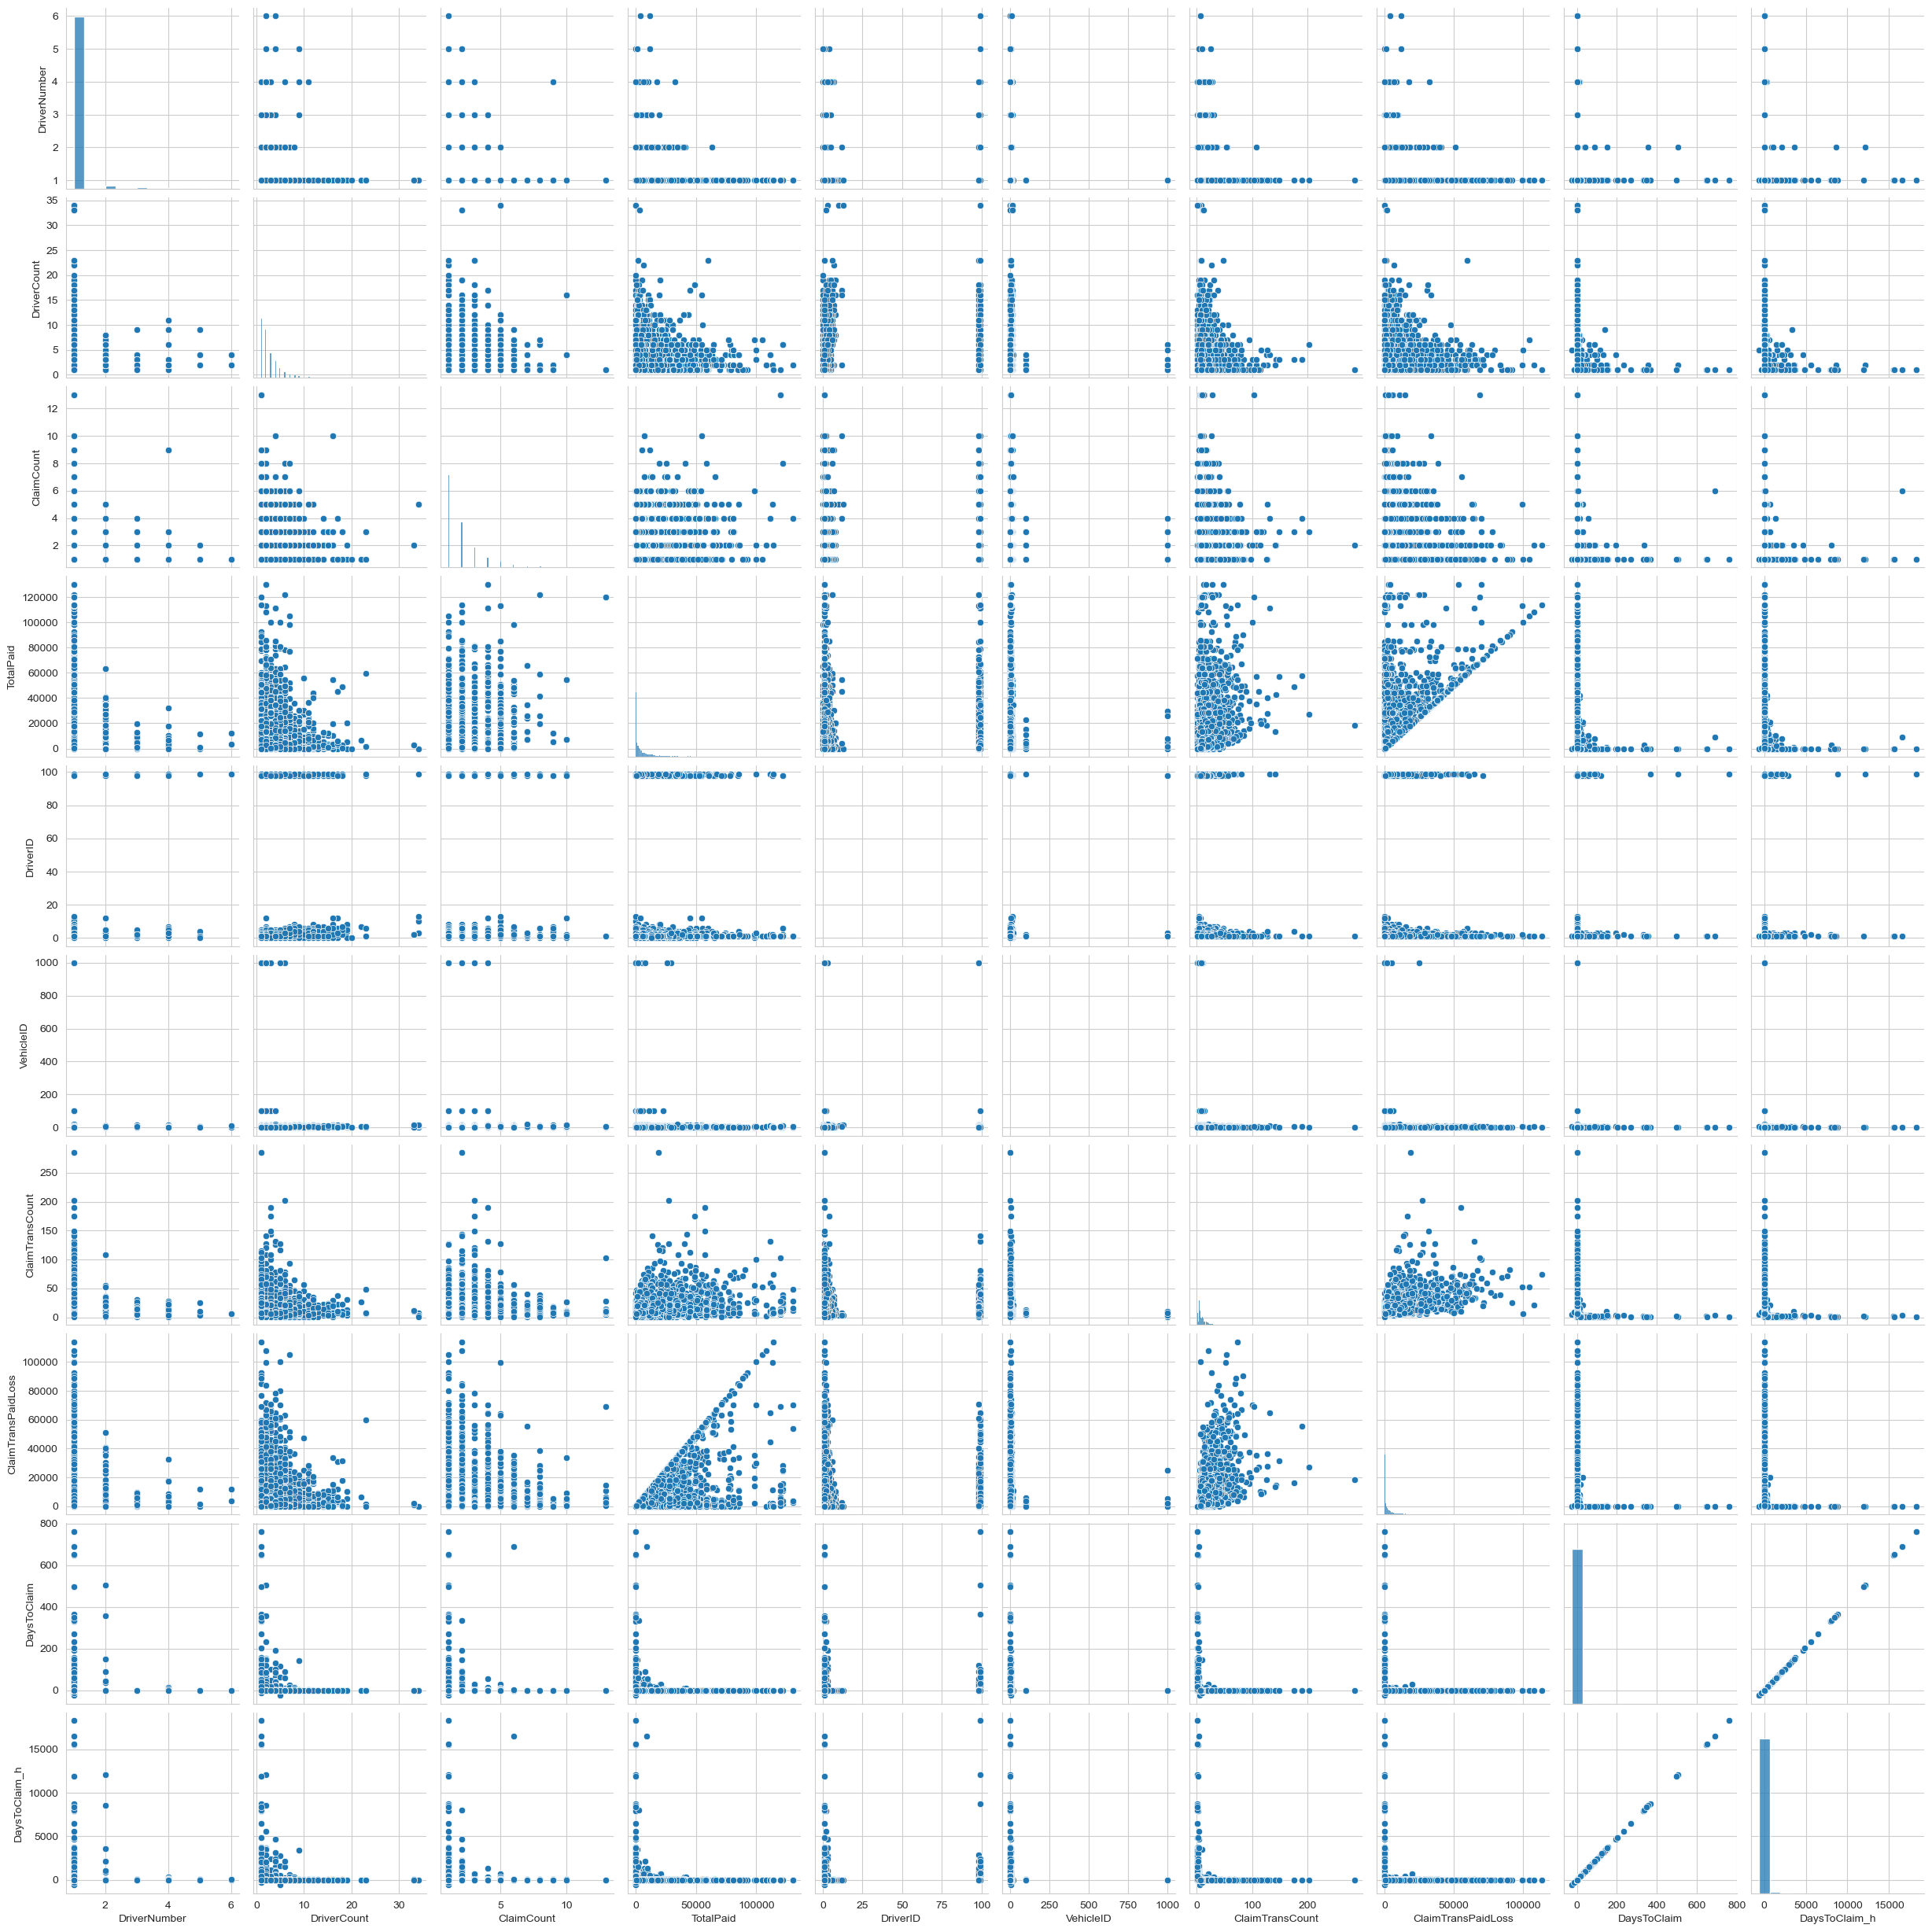

In [10]:
# Pair plot for TG
sns.pairplot(df_TG)
plt.show()


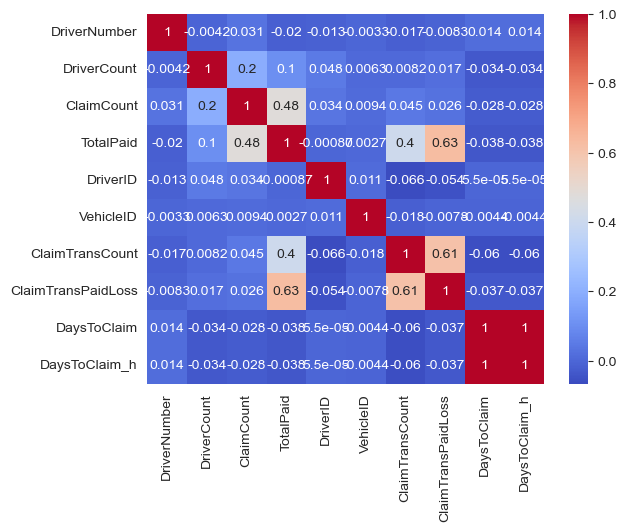

In [11]:
# Heat map for TG
correlation_matrix = df_TG.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.show()

#### When looking at the pair plots, we see that there are some trends between each predictor, but typically not that strong or the pair have a exponential relationship. This is further proved by the heatmap which shows that most have very weak relationships with eachother. This will hopefully lead to less multicollinearity in our modeling. 

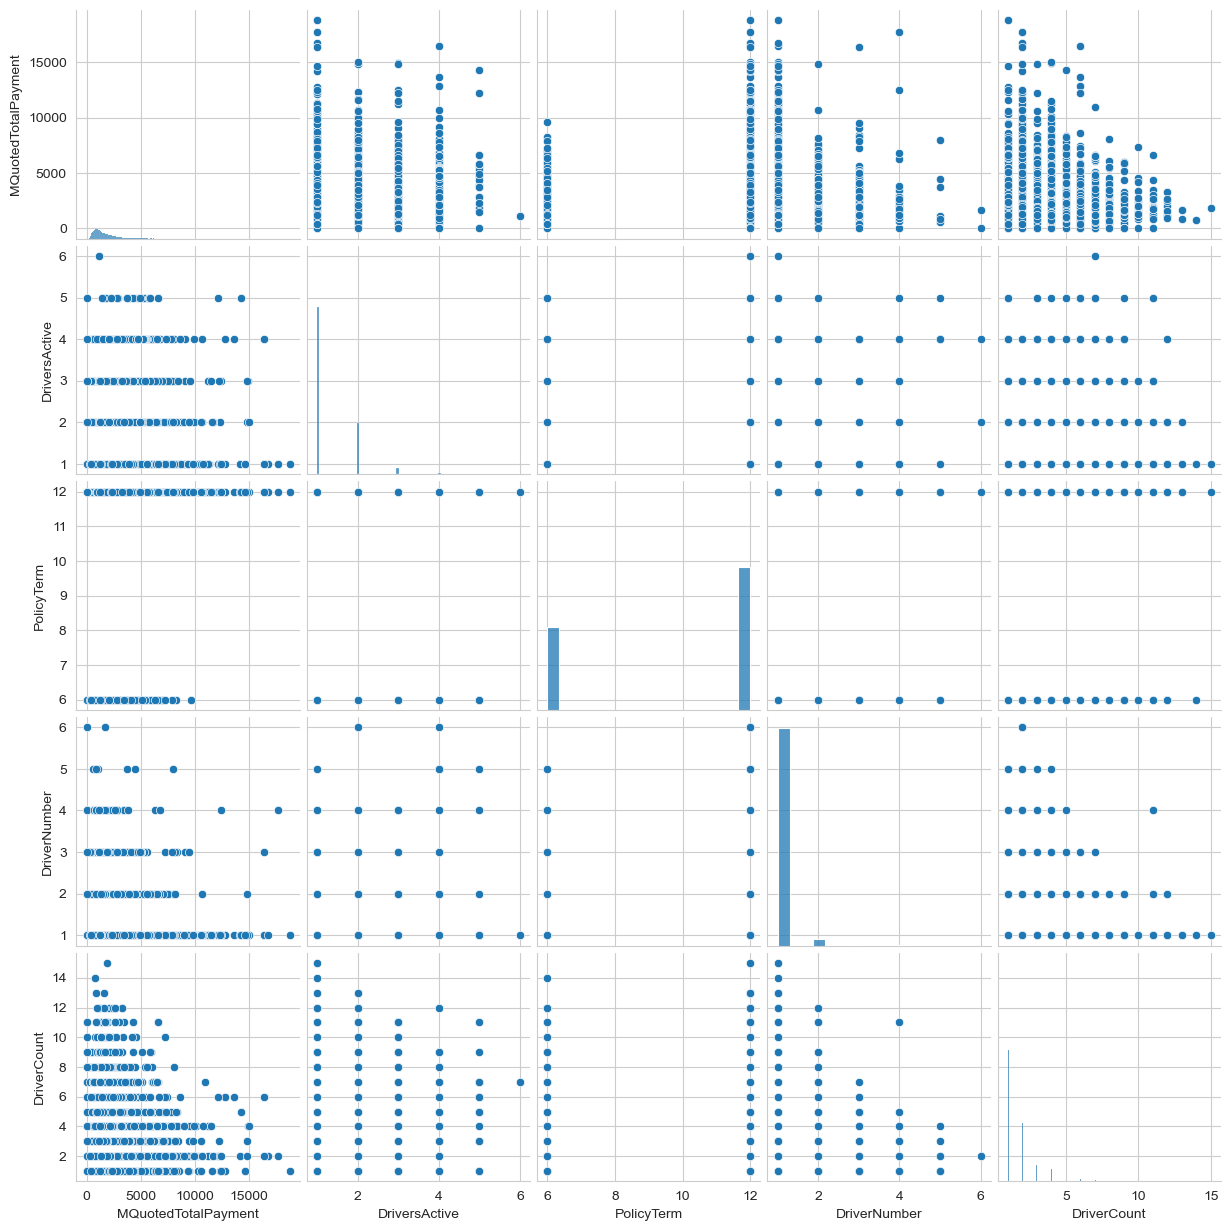

In [12]:
# Pair plot for MQ
sns.pairplot(df_MQ)
plt.show()

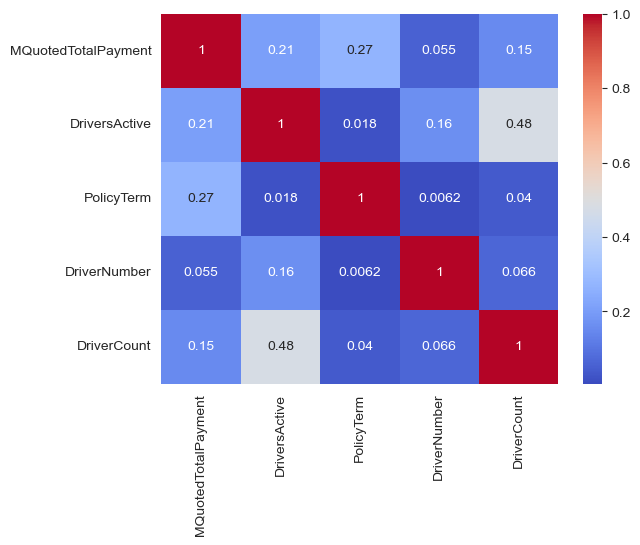

In [13]:
# Heat map for MQ
correlation_matrix = df_MQ.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.show()

#### Like df_TG, we are not seeing super strong relationships between the predictors. The strongest relationship is .48 which is DriverCount and DriversActive, which makes sense. This should help with our model have lots of different information brought in which will hopefully lead to a better predicting model. 

# EDA for TA

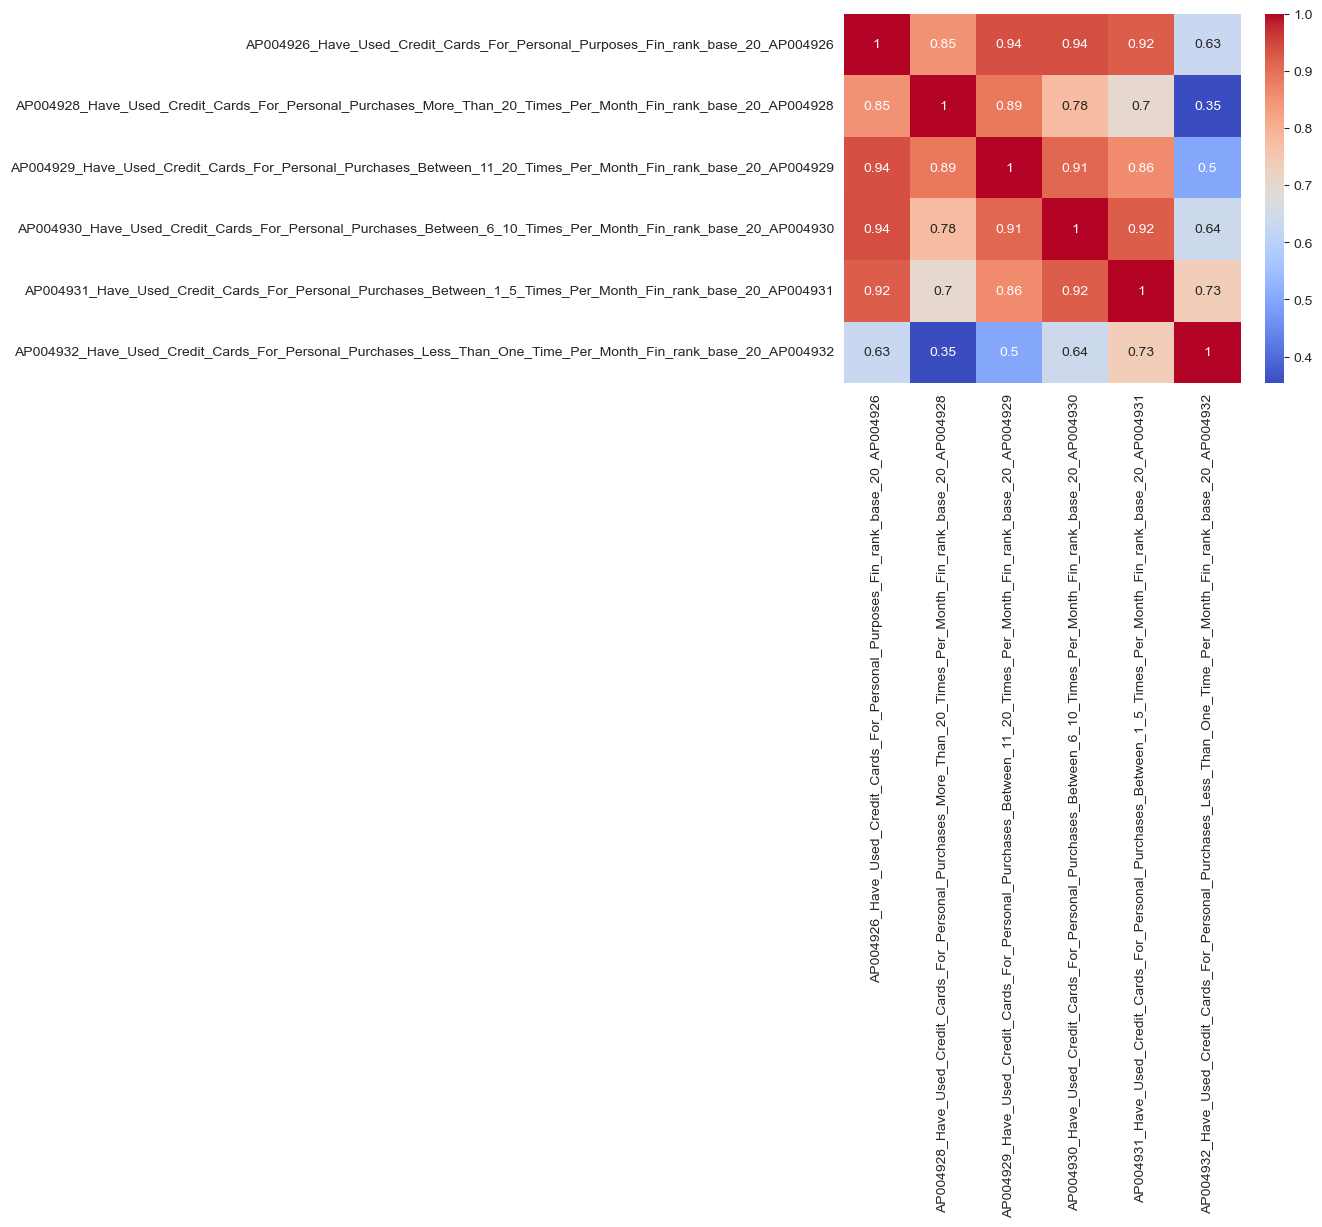

In [14]:
correlation_matrix = df_AT.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.show()

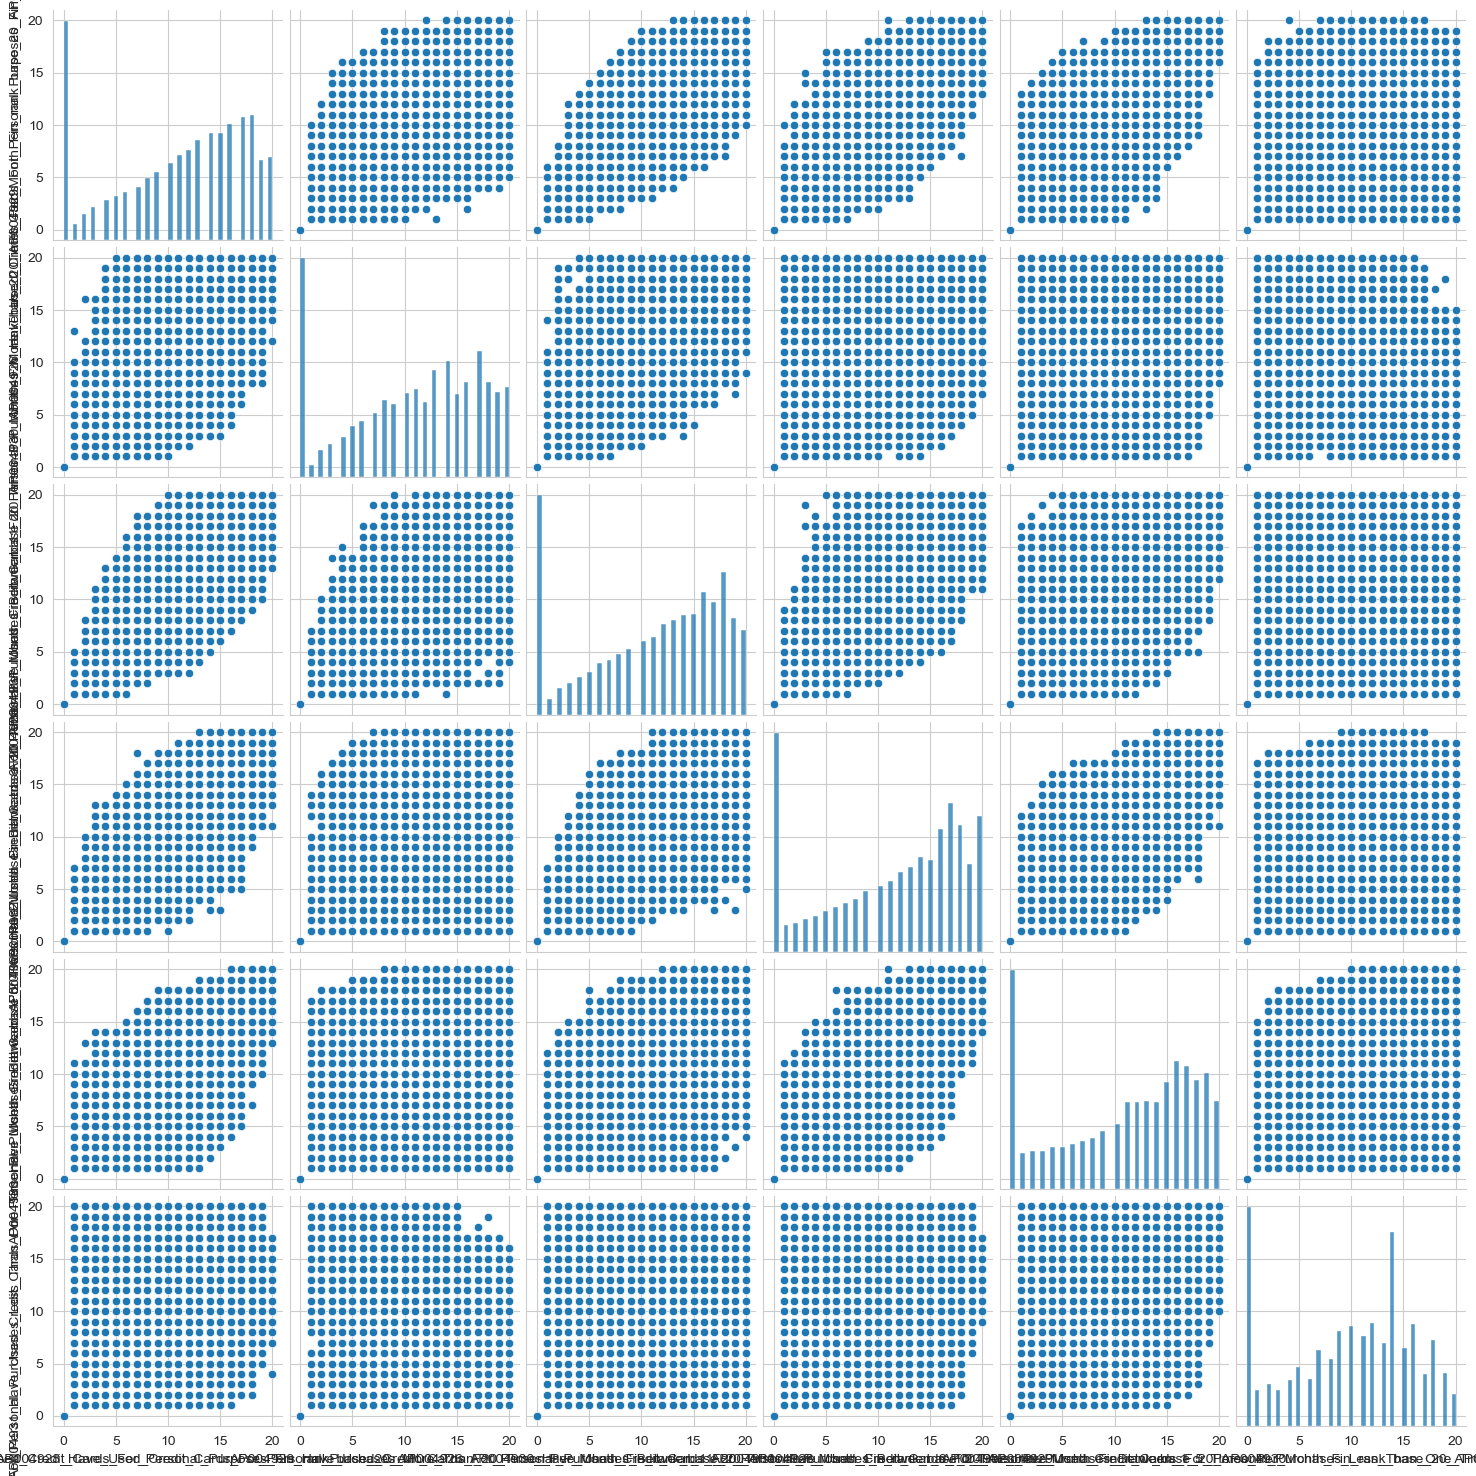

In [15]:
# Pair plot for AT
sns.pairplot(df_AT)
plt.show()

#### We widdled down our AT dataset quite a bit, but we now have a multicolinearity. This isn't a surpirse since all columns are very similar, so hopefully our models are able to exclude or penalize these highly correlated predictors. The pair plot isn't the most useful, but in some of the plots, we can see that there is a bit of a linear trend, which makes sense as to why some are heavily related to eachother. Overall, I think we have a good dataset to work with that is quite a tall data set. For my models, I plan on doing a random forest first because I believe it will be a top performer. Then I want to do a gradient boosting model. Finally, I want to build a lasso to see if we can get away with a simpler model even though this dataset is tall. 

## First Merge / Imputation of TA and MQ


In [16]:
merged_df = pd.merge(df_MQ, df_AT, on='AbilitecContactID', how='inner')
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 34975 entries, 0 to 34974
Data columns (total 18 columns):
 #   Column                                                                                                          Non-Null Count  Dtype  
---  ------                                                                                                          --------------  -----  
 0   MQuotedTotalPayment                                                                                             34975 non-null  float64
 1   BiFcCoverageInd                                                                                                 34975 non-null  object 
 2   CoverageTypeDescription                                                                                         34975 non-null  object 
 3   DriversActive                                                                                                   34975 non-null  int64  
 4   GaragingState                           

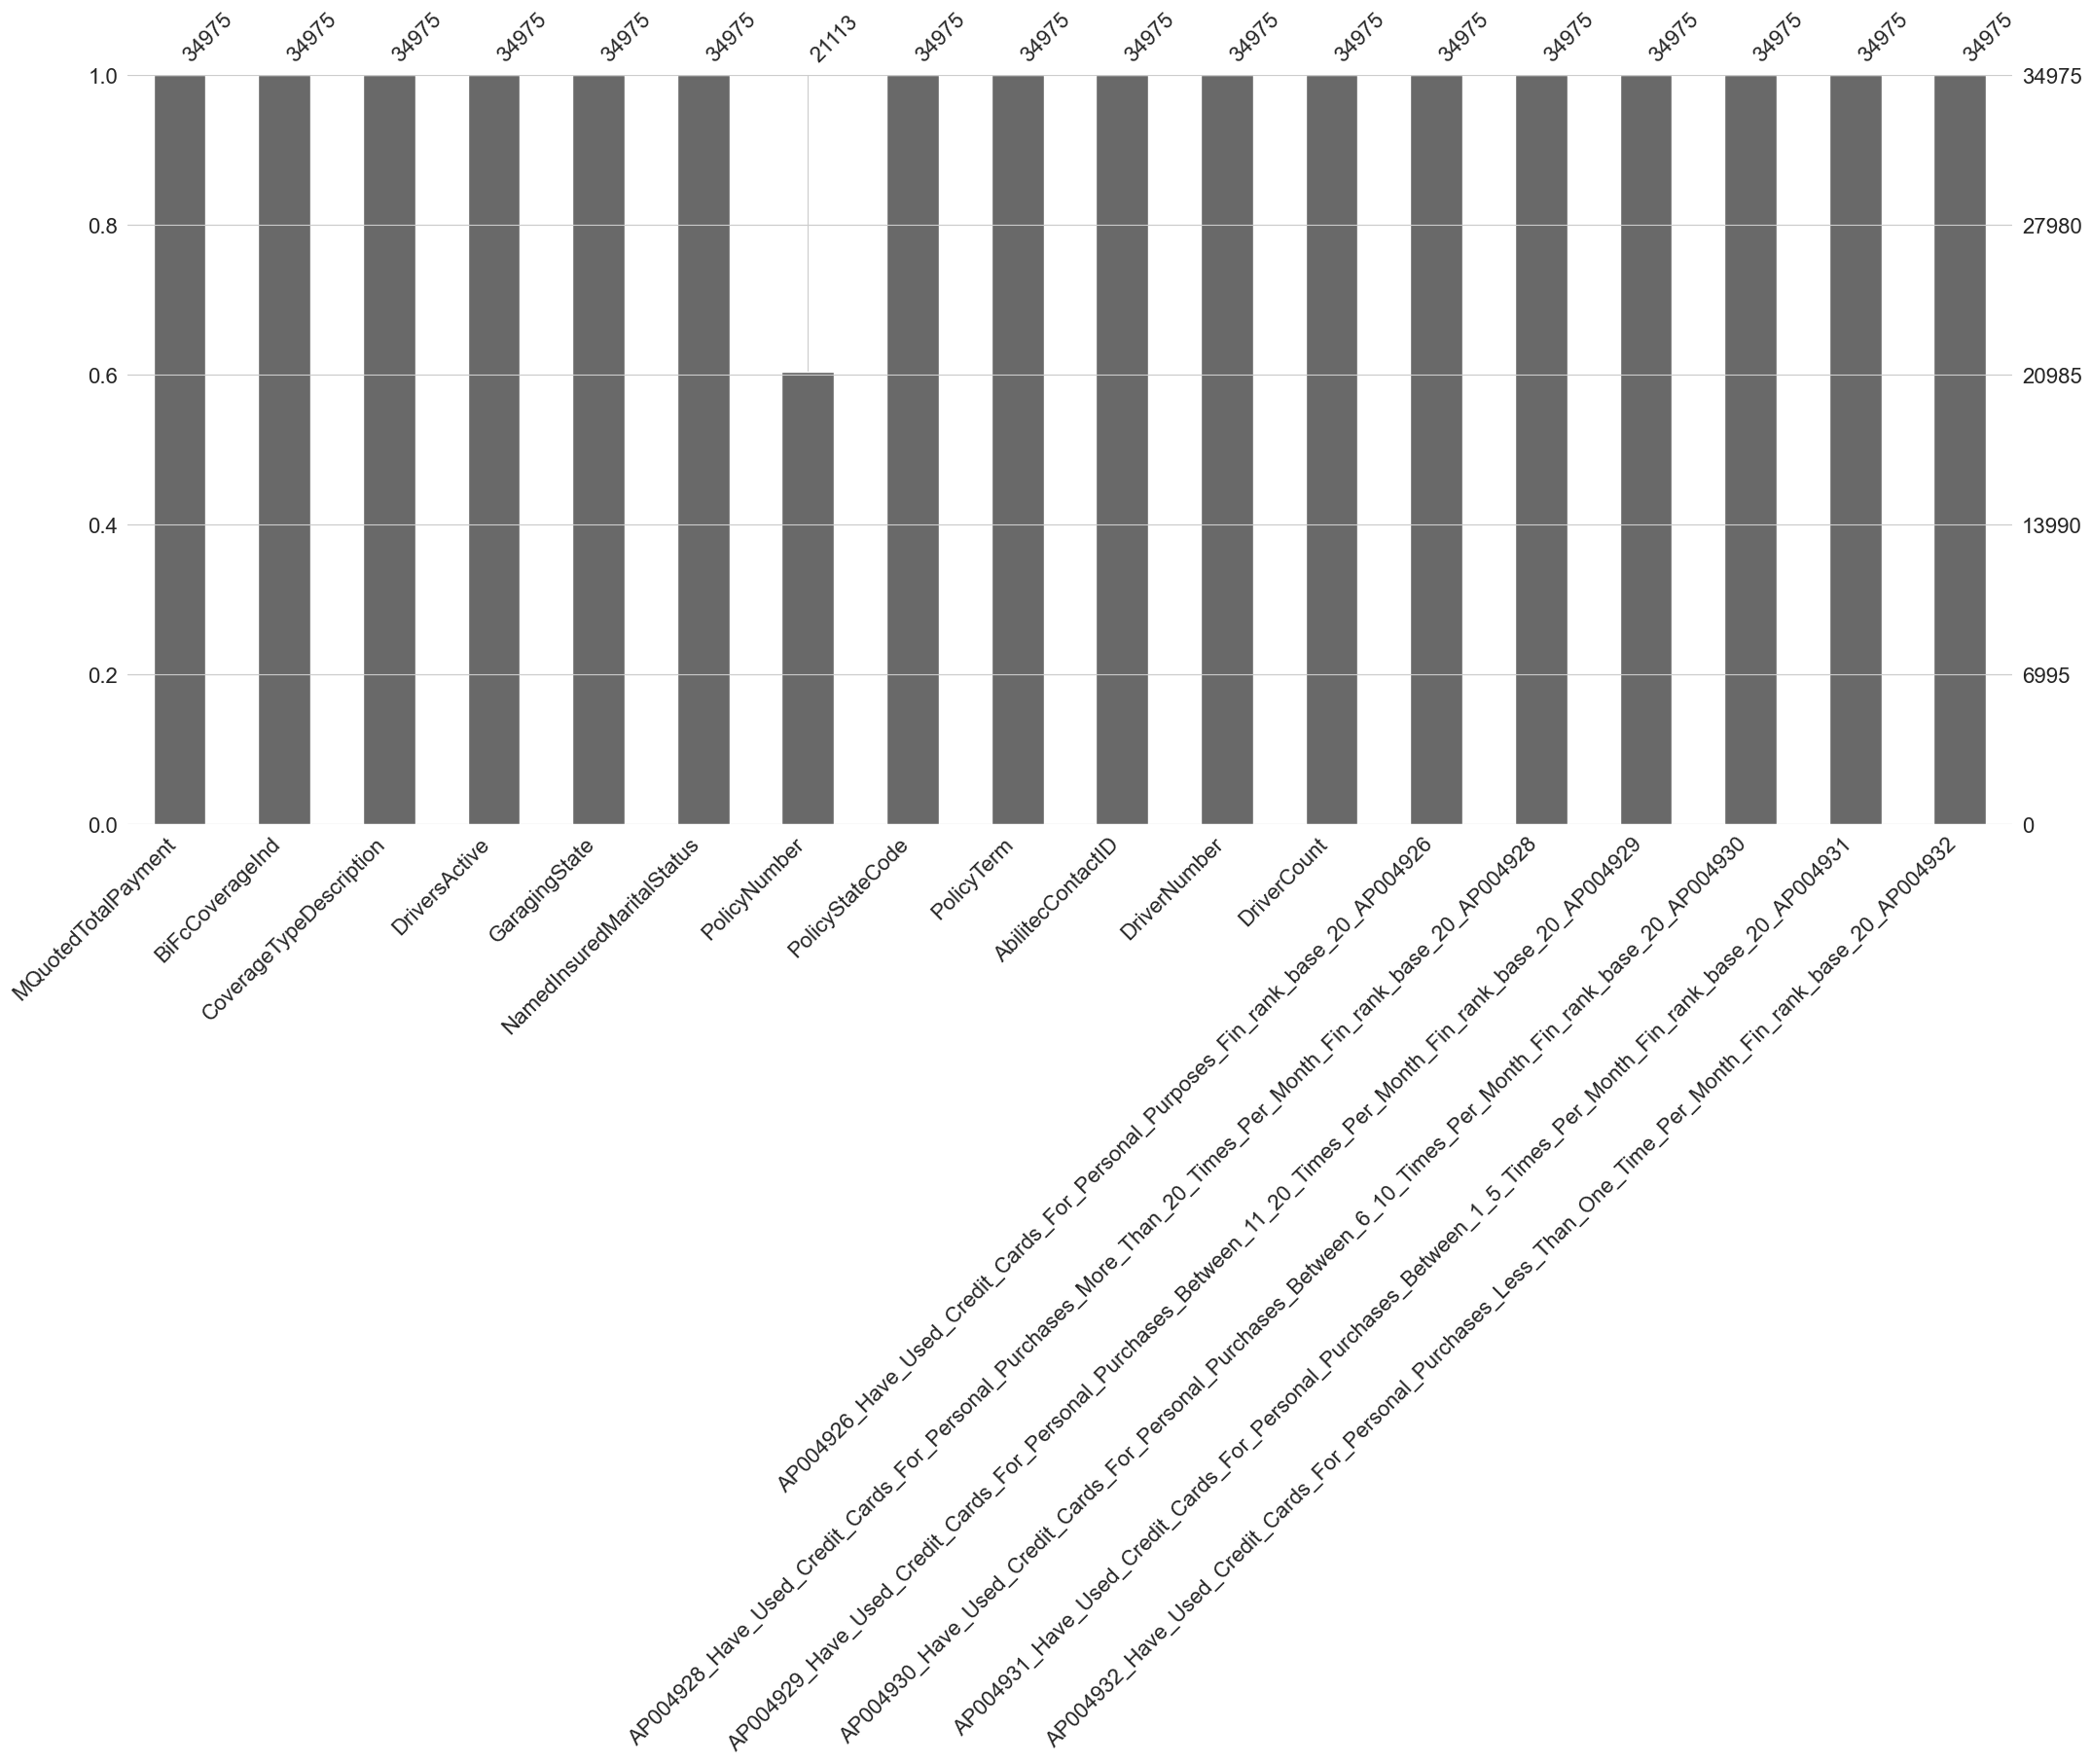

In [17]:
msno.bar(merged_df)
plt.show()

<Axes: >

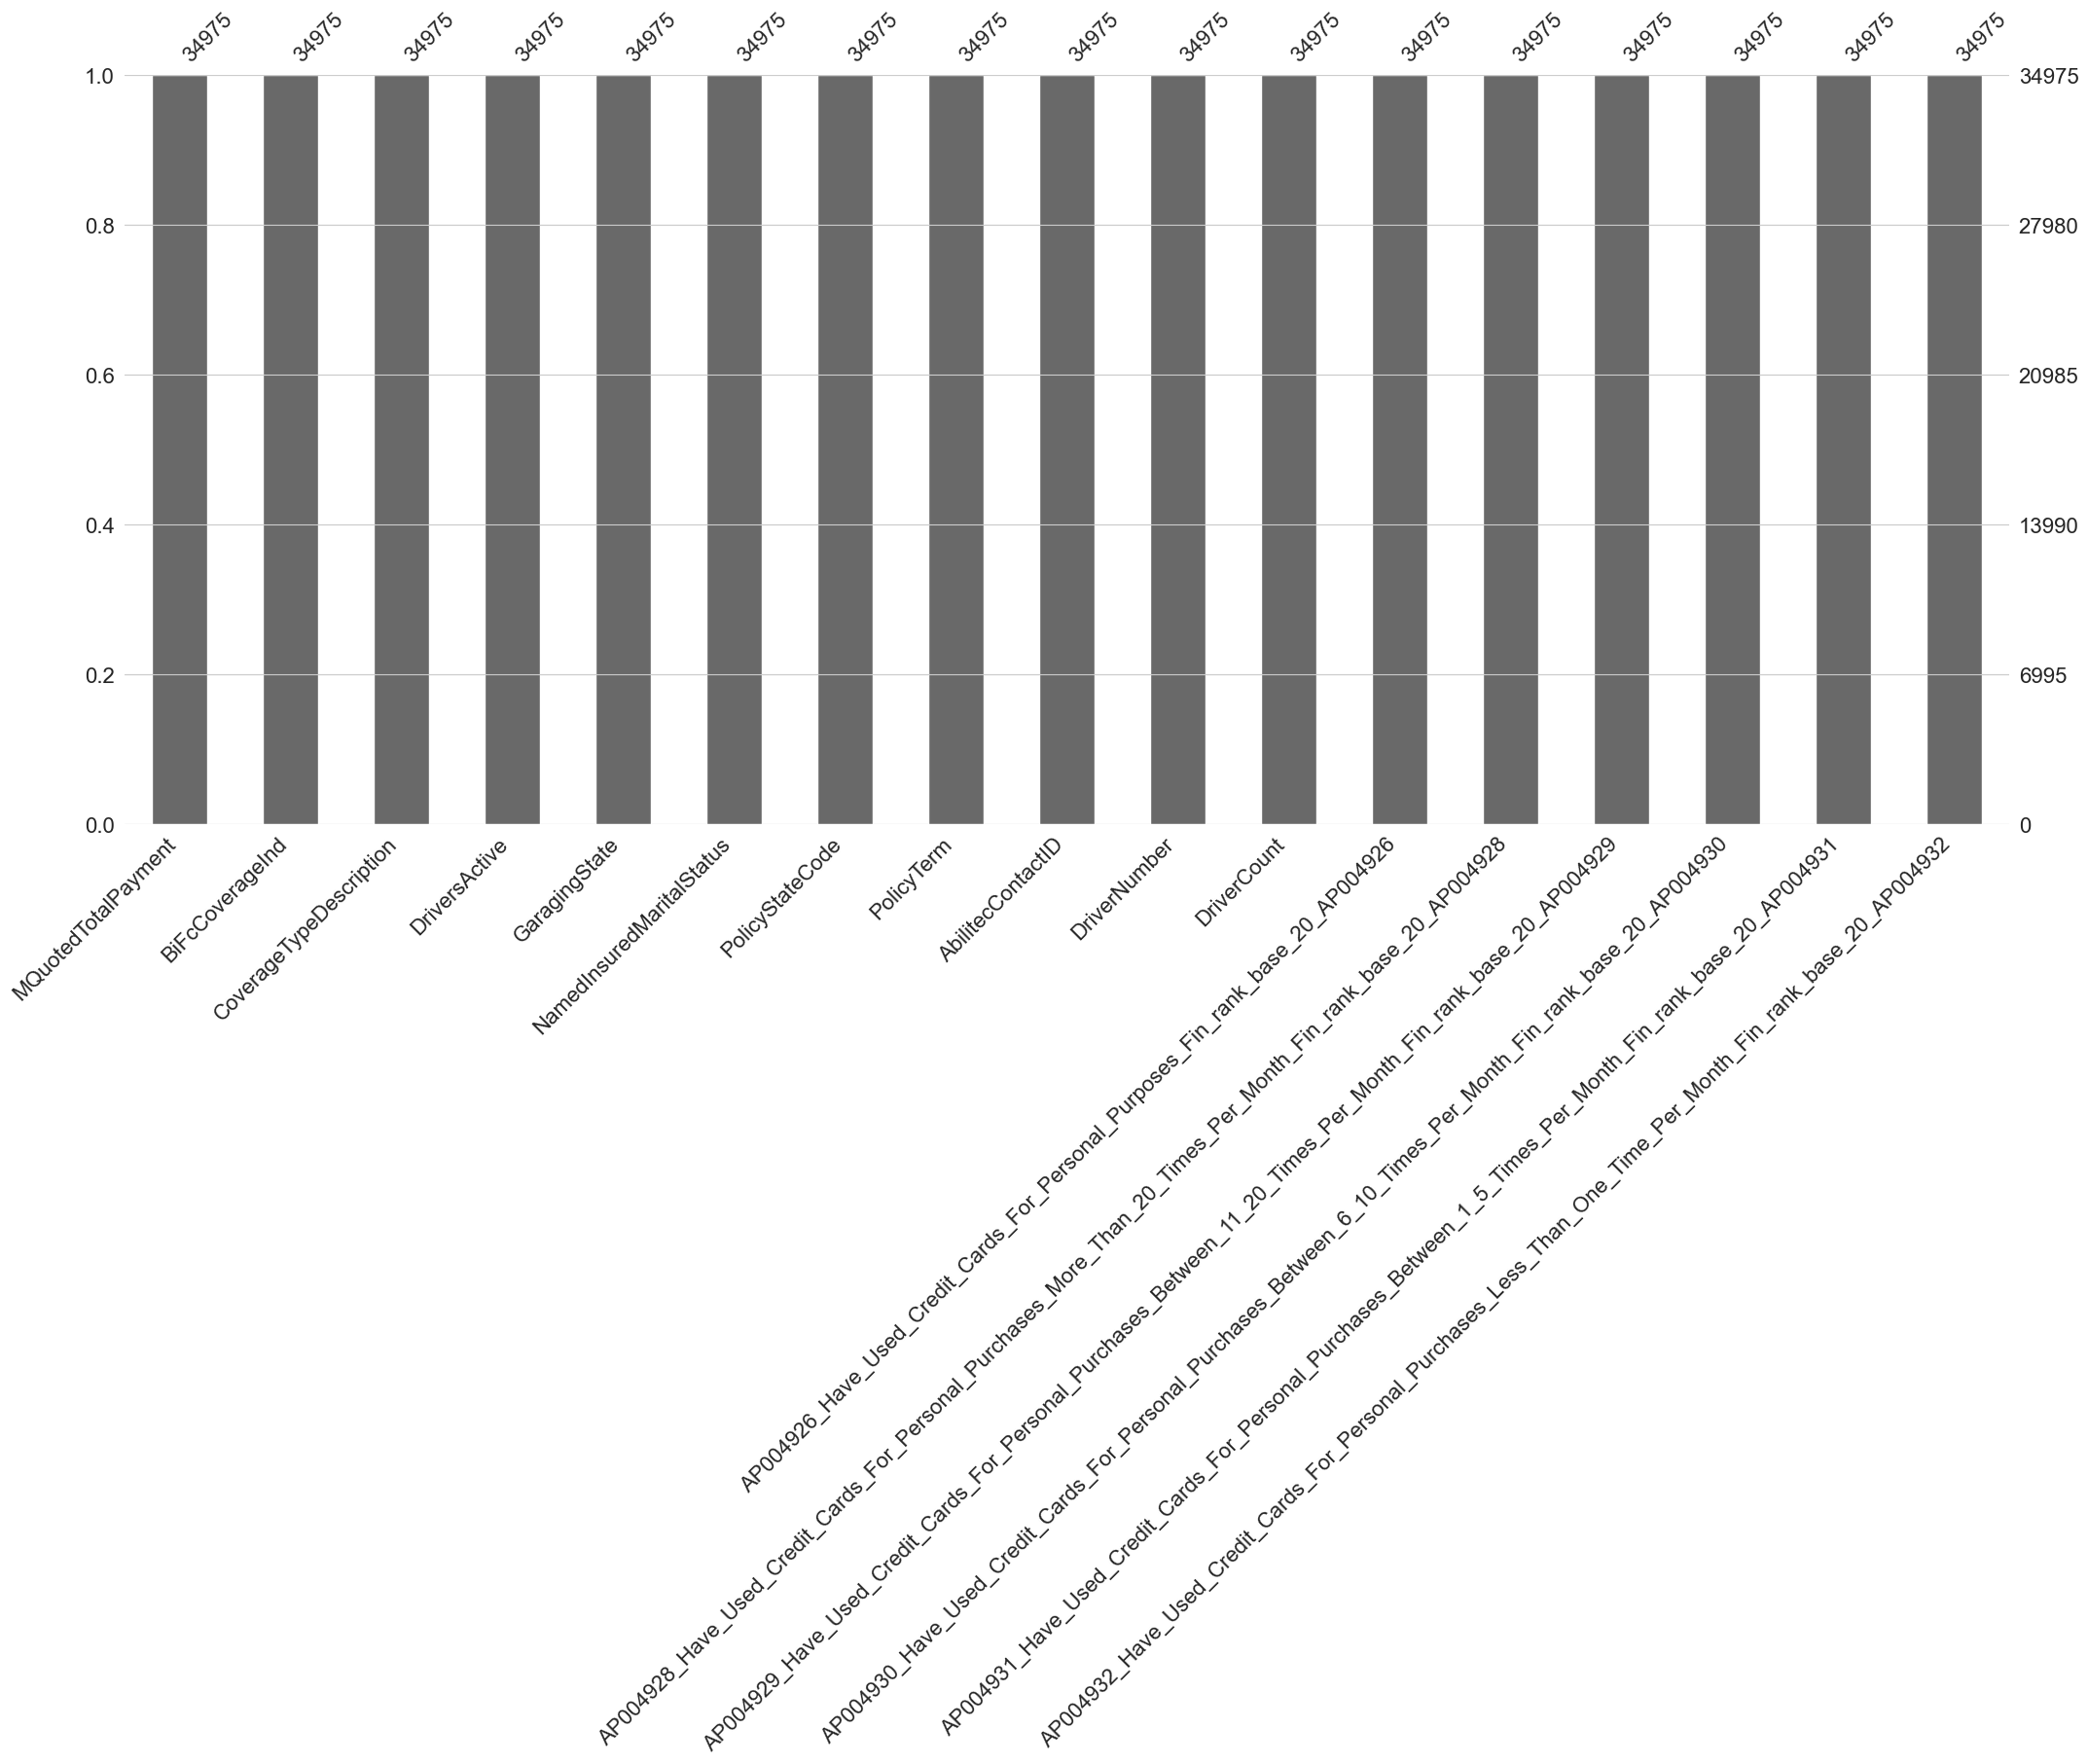

In [18]:
# Our only column that has missing values is PolicyNumber. We are going to drop this column because the policy number will is assigned sequintially and will not help us with predictive power. 
column_to_drop = "PolicyNumber"

# Drop the specified column
merged_df = merged_df.drop(column_to_drop, axis=1)
msno.bar(merged_df)

In [19]:
# We need to drop CoverageTypeDescription as it is obvious that the more coverage you have, the more your quote. We will also drop the Policy term because the longer the term, the most it will cost. 
merged_df = merged_df.drop(["CoverageTypeDescription", "PolicyTerm", 'BiFcCoverageInd'], axis=1)
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 34975 entries, 0 to 34974
Data columns (total 14 columns):
 #   Column                                                                                                          Non-Null Count  Dtype  
---  ------                                                                                                          --------------  -----  
 0   MQuotedTotalPayment                                                                                             34975 non-null  float64
 1   DriversActive                                                                                                   34975 non-null  int64  
 2   GaragingState                                                                                                   34975 non-null  object 
 3   NamedInsuredMaritalStatus                                                                                       34975 non-null  object 
 4   PolicyStateCode                         

#### We now have no more missing values in our merged dataframe. We need to do the same thing now but for the merge of df_TG and df_AT

## Second Merge / Imputation of AT and TG

In [20]:
# Earlier we saw that TG had missing values in the last four columns, so I wanted to take a differenct approach and just drop all the rows that are missing data in those columns.
# My thought process is that i want to speed up computational times and I'm interested to see how this will change the results compared to how other people handled the data imputation. 

df_TG.dropna(subset=['ClaimTransCount'], inplace=True)
df_TG.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9780 entries, 0 to 11068
Data columns (total 22 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   AbilitecContactID    9780 non-null   object 
 1   PolicyNumber         9780 non-null   object 
 2   DriverNumber         9780 non-null   int64  
 3   AbilitecHouseholdID  9780 non-null   object 
 4   DriverCount          9780 non-null   int64  
 5   ClaimCount           9780 non-null   int64  
 6   TotalPaid            9780 non-null   float64
 7   ClaimNumber          9780 non-null   object 
 8   AtFaultDescription   9780 non-null   object 
 9   ClaimStatus          9780 non-null   object 
 10  ClaimType            9780 non-null   object 
 11  DateOfLoss           9780 non-null   object 
 12  DriverID             9780 non-null   int64  
 13  LossState            9780 non-null   object 
 14  PolicyStateCode      9780 non-null   object 
 15  SubrogrationFlag     9780 non-null   

In [21]:
# We now have no more missing values, so we can merge with df_AT on the id. 
merged2_df = pd.merge(df_TG, df_AT, on='AbilitecContactID', how='inner')
# Drop the columns that don't need to be dummy variables and add little value to the model.
merged2_df = merged2_df.drop(['AbilitecContactID', 'AbilitecHouseholdID', 'ClaimNumber', 'PolicyNumber', 'ClaimTransCount', 'TermEffectiveDate', 'DateOfLoss'], axis = 1)
merged2_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9780 entries, 0 to 9779
Data columns (total 21 columns):
 #   Column                                                                                                          Non-Null Count  Dtype  
---  ------                                                                                                          --------------  -----  
 0   DriverNumber                                                                                                    9780 non-null   int64  
 1   DriverCount                                                                                                     9780 non-null   int64  
 2   ClaimCount                                                                                                      9780 non-null   int64  
 3   TotalPaid                                                                                                       9780 non-null   float64
 4   AtFaultDescription                        

## Dummy Variables
First, let's drop our y from our predictors so we can make the dummy variables. 

In [22]:
data_df = merged_df.drop(['MQuotedTotalPayment', 'AbilitecContactID'], axis = 1)
data_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 34975 entries, 0 to 34974
Data columns (total 12 columns):
 #   Column                                                                                                          Non-Null Count  Dtype  
---  ------                                                                                                          --------------  -----  
 0   DriversActive                                                                                                   34975 non-null  int64  
 1   GaragingState                                                                                                   34975 non-null  object 
 2   NamedInsuredMaritalStatus                                                                                       34975 non-null  object 
 3   PolicyStateCode                                                                                                 34975 non-null  object 
 4   DriverNumber                            

In [23]:
# Now let's get dummy variables for all of the categorical predictors
categorical_columns = data_df.select_dtypes(include=['object']).columns

# Create dummy variables for categorical predictors
data_df = pd.get_dummies(data_df, columns=categorical_columns)

# Display information about the DataFrame
data_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 34975 entries, 0 to 34974
Columns: 110 entries, DriversActive to PolicyStateCode_WY
dtypes: float64(6), int64(3), uint8(101)
memory usage: 6.0 MB


In [24]:
# This is getting a little a head for this section, but I want to create my binary classification target variable.
# Calculate the mean of ClaimTransCount
mean_claim_trans_count = df_TG['ClaimCount'].mean()

# Create a binary target variable
merged2_df['HighRisk'] = (merged2_df['ClaimCount'] > mean_claim_trans_count).astype(int)
merged2_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9780 entries, 0 to 9779
Data columns (total 22 columns):
 #   Column                                                                                                          Non-Null Count  Dtype  
---  ------                                                                                                          --------------  -----  
 0   DriverNumber                                                                                                    9780 non-null   int64  
 1   DriverCount                                                                                                     9780 non-null   int64  
 2   ClaimCount                                                                                                      9780 non-null   int64  
 3   TotalPaid                                                                                                       9780 non-null   float64
 4   AtFaultDescription                        

In [25]:
# Drop all columns too closely related to the target or that have no influence on the model
merged2_df = merged2_df.drop(['DriverNumber'], axis = 1)

# Now let's get dummy variables for all of the categorical predictors
categorical_columns = merged2_df.select_dtypes(include=['object']).columns

# Create dummy variables for categorical predictors
merged2_df = pd.get_dummies(merged2_df, columns=categorical_columns)

# Display information about the DataFrame
merged2_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9780 entries, 0 to 9779
Columns: 180 entries, DriverCount to SubrogrationFlag_YES
dtypes: float64(10), int32(1), int64(4), uint8(165)
memory usage: 2.7 MB


In [26]:
# This created a lot of clumns for our merged2_df. We are most likely going to need higher complexity models to deal with this dataset. 

#### We are now ready to start building our models. We have removed or replaced all missing values. We have created dummy variables for our categorical predictors as well. We have 118 columns and 34975 rows of data. We are definitely going to need to reduce the predictors since we are looking to interperet the model.

## Regression Models

In [27]:
# Assign the variables and split the dataset
X = data_df
y = merged_df['MQuotedTotalPayment']  # Keep target variable only for y

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Standardize the features
scaler = StandardScaler()

# Fit the scaler on the training data and transform both training and test data
X_train_sc = scaler.fit_transform(X_train)
X_test_sc = scaler.transform(X_test)

In [28]:
# The function below is necessary to accurately figure out MAPE
# We were dividing by zero which throws off the MAPE, so this adds a small value to it to prevent that
def safe_mean_absolute_percentage_error(y_true, y_pred, epsilon=1e-10):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    non_zero_mask = y_true != 0
    y_true_non_zero = y_true[non_zero_mask]
    y_pred_non_zero = y_pred[non_zero_mask]
    percentage_errors = np.abs((y_true_non_zero - y_pred_non_zero) / y_true_non_zero)
    mape = np.mean(percentage_errors)
    return mape




In [29]:
# The function below is necessary to accurately figure out MAPE
# We were dividing by zero which throws off the MAPE, so this adds a small value to it to prevent that
def safe_mean_absolute_percentage_error(y_true, y_pred, epsilon=1e-10):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    non_zero_mask = y_true != 0
    y_true_non_zero = y_true[non_zero_mask]
    y_pred_non_zero = y_pred[non_zero_mask]
    percentage_errors = np.abs((y_true_non_zero - y_pred_non_zero) / y_true_non_zero)
    mape = np.mean(percentage_errors)
    return mape

# Define the parameter grid for random forest model.
param_grid = {
    'n_estimators': [1, 5, 10, 20],
    'max_depth': [1, 5, 10],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['auto', 'sqrt', 'log2']
}

# Create the Random Forest model
rf_model = RandomForestRegressor(random_state=42)

# Perform grid search with cross-validation
grid_search = GridSearchCV(rf_model, param_grid, cv=5, scoring='neg_mean_squared_error')
grid_search.fit(X_train_sc, y_train)

# Get the best hyperparameters from the grid search
best_params = grid_search.best_params_

# Fit the Random Forest model with the best hyperparameters
best_rf_model = RandomForestRegressor(random_state=42, **best_params)
best_rf_model.fit(X_train_sc, y_train)

# Make predictions on the test dataset
y_pred_test_rf = best_rf_model.predict(X_test_sc)
mape = safe_mean_absolute_percentage_error(y_test, y_pred_test_rf)
# Calculate the performance metrics
rmse_rf = np.sqrt(mean_squared_error(y_test, y_pred_test_rf))
mae_rf = mean_absolute_error(y_test, y_pred_test_rf)
r2_rf = r2_score(y_test, y_pred_test_rf)

mape_rf = safe_mean_absolute_percentage_error(y_test, y_pred_test_rf)

# Print the results
print("Random Forest Regression Results:")
print("Best Hyperparameters:", best_params)
print(f"Root Mean Squared Error (RMSE): {rmse_rf:.2f}")
print(f"Mean Absolute Error (MAE): {mae_rf:.2f}")
print(f"Mean Absolute Percentage Error (MAPE): {mape_rf:.2f}%")
print(f"R-squared (R²): {r2_rf:.4f}")

Random Forest Regression Results:
Best Hyperparameters: {'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 20}
Root Mean Squared Error (RMSE): 1148.61
Mean Absolute Error (MAE): 791.26
Mean Absolute Percentage Error (MAPE): 0.58%
R-squared (R²): 0.1438


In [30]:
# Define the parameter grid for XGBoost
param_grid = {
    'n_estimators': [50, 100, 150],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0],
}

# Create the XGBoost model
xgb_model = xgb.XGBRegressor(random_state=42)

# Perform grid search with cross-validation
grid_search = GridSearchCV(xgb_model, param_grid, cv=5, scoring='neg_mean_squared_error')
grid_search.fit(X_train_sc, y_train)

# Get the best hyperparameters from the grid search
best_params = grid_search.best_params_

# Fit the XGBoost model with the best hyperparameters
best_xgb_model = xgb.XGBRegressor(random_state=42, **best_params)
best_xgb_model.fit(X_train_sc, y_train)

# Make predictions on the test dataset
y_pred_test_xgb = best_xgb_model.predict(X_test_sc)

# Calculate the performance metrics
rmse_xgb = np.sqrt(mean_squared_error(y_test, y_pred_test_xgb))
mae_xgb = mean_absolute_error(y_test, y_pred_test_xgb)
r2_xgb = r2_score(y_test, y_pred_test_xgb)
mape_xgb = safe_mean_absolute_percentage_error(y_test, y_pred_test_xgb)

# Print the results
print("XGBoost Regression Results:")
print("Best Hyperparameters:", best_params)
print(f"Root Mean Squared Error (RMSE): {rmse_xgb:.2f}")
print(f"Mean Absolute Error (MAE): {mae_xgb:.2f}")
print(f"Mean Absolute Percentage Error (MAPE): {mape_xgb:.2f}%")
print(f"R-squared (R²): {r2_xgb:.4f}")

XGBoost Regression Results:
Best Hyperparameters: {'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 150, 'subsample': 0.8}
Root Mean Squared Error (RMSE): 1103.62
Mean Absolute Error (MAE): 753.26
Mean Absolute Percentage Error (MAPE): 0.53%
R-squared (R²): 0.2096


In [31]:
# Define the parameter grid for lasso.
lasso_param_grid = {
    'alpha': [0.001, 0.01, 0.1, 1, 10],
}

# Create the Lasso model
lasso_model = Lasso()

# Perform grid search with cross-validation
lasso_grid_search = GridSearchCV(lasso_model, lasso_param_grid, cv=5, scoring='neg_mean_squared_error')
lasso_grid_search.fit(X_train_sc, y_train)

# Get the best hyperparameters from the grid search
best_lasso_params = lasso_grid_search.best_params_

# Fit the Lasso model with the best hyperparameters
best_lasso_model = Lasso(**best_lasso_params)
best_lasso_model.fit(X_train_sc, y_train)

# Make predictions on the test dataset
y_pred_test_lasso = best_lasso_model.predict(X_test_sc)

# Calculate the performance metrics
rmse_lasso = np.sqrt(mean_squared_error(y_test, y_pred_test_lasso))
mae_lasso = mean_absolute_error(y_test, y_pred_test_lasso)
r2_lasso = r2_score(y_test, y_pred_test_lasso)
mape_lasso = safe_mean_absolute_percentage_error(y_test, y_pred_test_lasso)

# Print the results
print("Lasso Regression Results:")
print("Best Hyperparameters:", best_lasso_params)
print(f"Root Mean Squared Error (RMSE): {rmse_lasso:.2f}")
print(f"Mean Absolute Error (MAE): {mae_lasso:.2f}")
print(f"Mean Absolute Percentage Error (MAPE): {mape_xgb:.2f}%")
print(f"R-squared (R²): {r2_lasso:.4f}")

Lasso Regression Results:
Best Hyperparameters: {'alpha': 1}
Root Mean Squared Error (RMSE): 1132.25
Mean Absolute Error (MAE): 775.89
Mean Absolute Percentage Error (MAPE): 0.53%
R-squared (R²): 0.1680


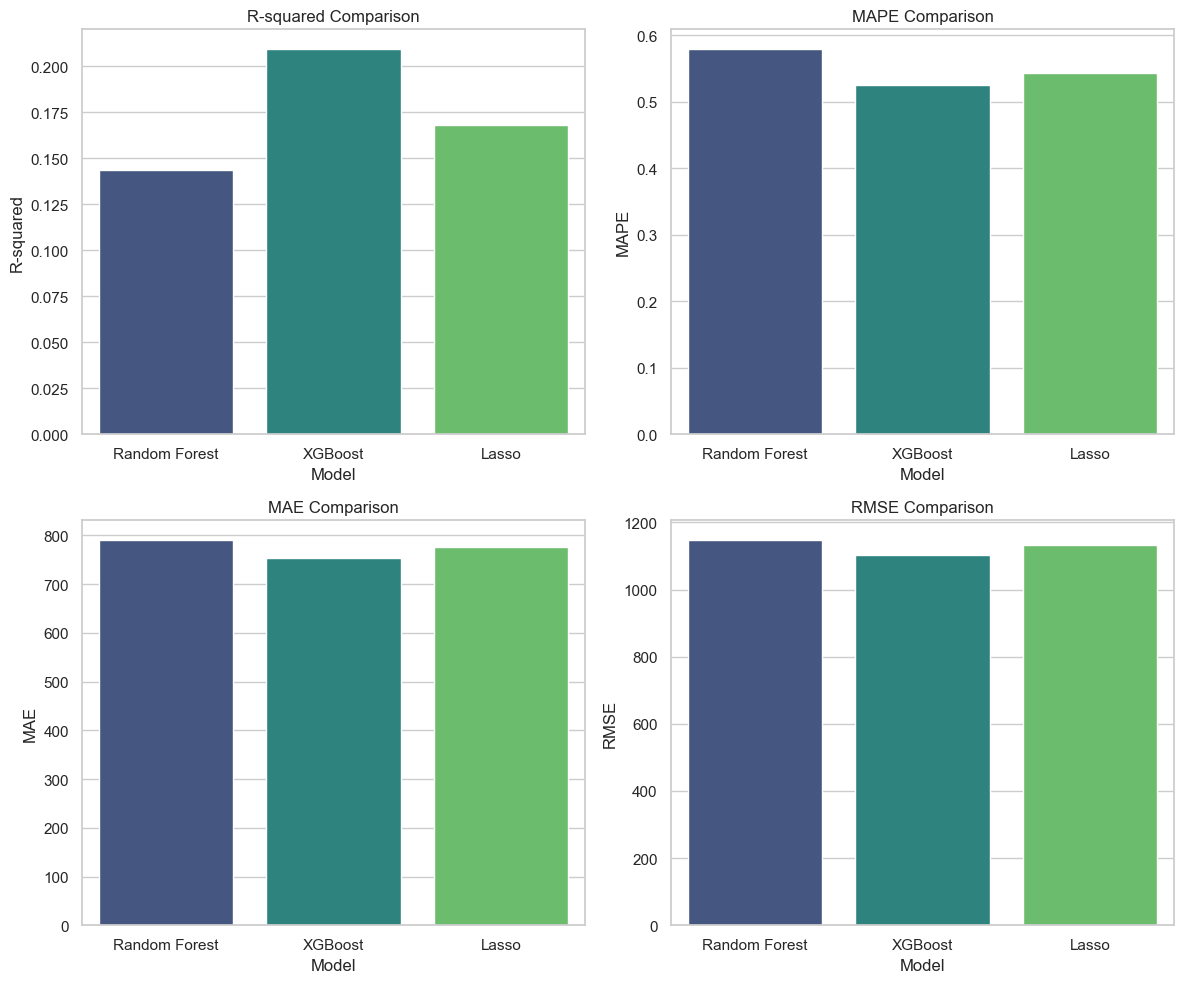

In [32]:
data = {
    'Model': ['Random Forest', 'XGBoost', 'Lasso'],
    'R-squared': [r2_rf, r2_xgb, r2_lasso],
    'MAPE': [mape_rf, mape_xgb, mape_lasso],
    'MAE': [mae_rf, mae_xgb, mae_lasso],
    'RMSE': [rmse_rf, rmse_xgb, rmse_lasso],
}

df_results = pd.DataFrame(data)

# Set the seaborn style
sns.set(style="whitegrid")

# Create subplots
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 10))

# Subplot 1: R-squared comparison
sns.barplot(x='Model', y='R-squared', data=df_results, palette='viridis', ax=axes[0, 0])
axes[0, 0].set_title('R-squared Comparison')

# Subplot 2: MAPE comparison
sns.barplot(x='Model', y='MAPE', data=df_results, palette='viridis', ax=axes[0, 1])
axes[0, 1].set_title('MAPE Comparison')

# Subplot 3: MAE comparison
sns.barplot(x='Model', y='MAE', data=df_results, palette='viridis', ax=axes[1, 0])
axes[1, 0].set_title('MAE Comparison')

# Subplot 4: RMSE comparison
sns.barplot(x='Model', y='RMSE', data=df_results, palette='viridis', ax=axes[1, 1])
axes[1, 1].set_title('RMSE Comparison')

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()

In [48]:
print(df_results)

           Model  R-squared      MAPE         MAE         RMSE
0  Random Forest   0.143813  0.579892  791.259847  1148.609266
1        XGBoost   0.209577  0.525702  753.255350  1103.615098
2          Lasso   0.168033  0.543522  775.893339  1132.246122


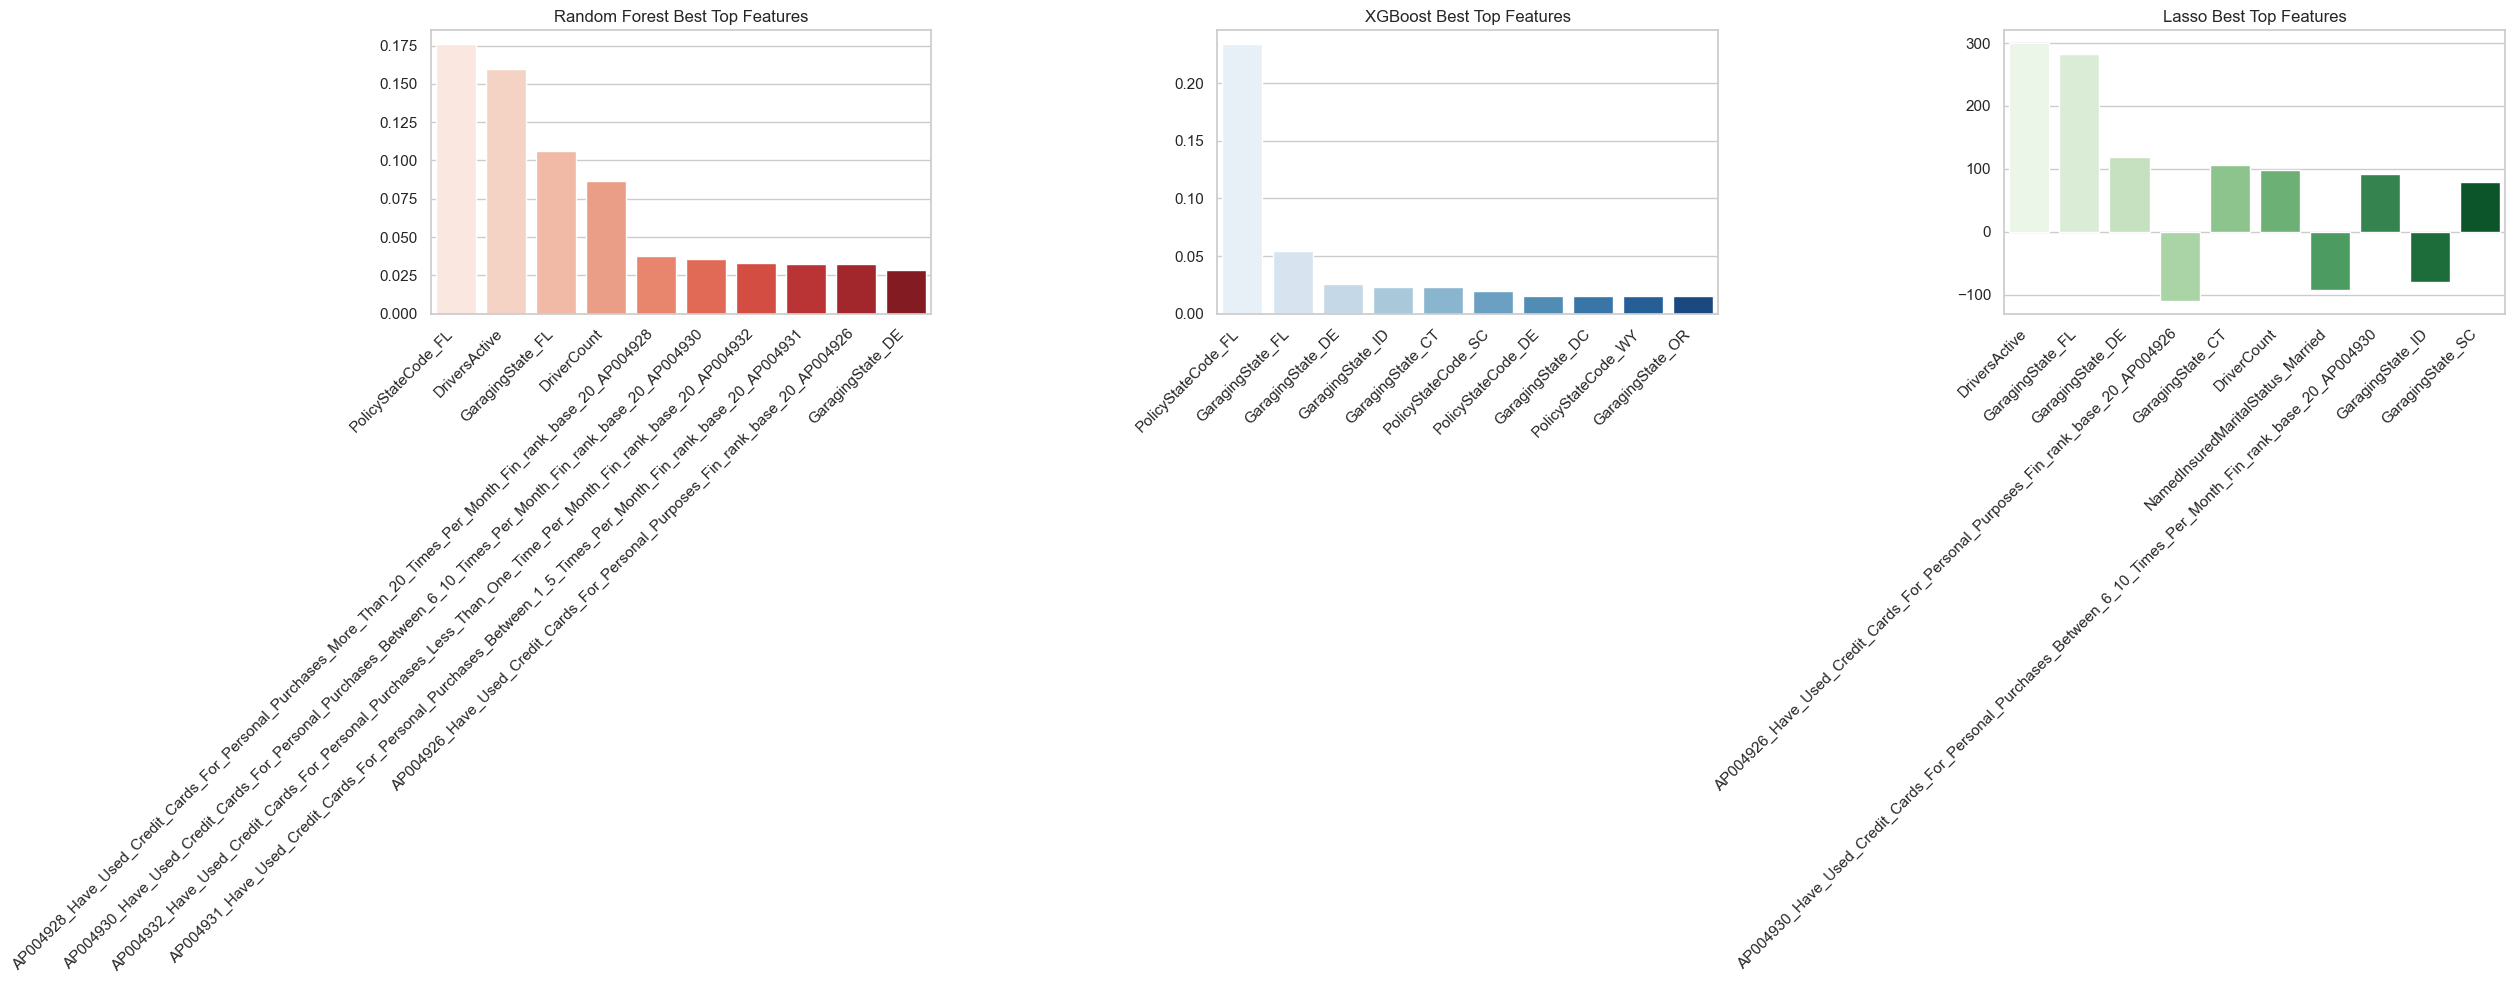

In [33]:
# Extract feature importances for XGBoost Best
feature_importance_xgb_best = list(zip(X_train.columns, best_xgb_model.feature_importances_))
feature_importance_xgb_best.sort(key=lambda x: x[1], reverse=True)
top_features_xgb_best = feature_importance_xgb_best[:10]

# Extract feature importances for Lasso Best
feature_importance_lasso_best = list(zip(X_train.columns, best_lasso_model.coef_))
feature_importance_lasso_best.sort(key=lambda x: abs(x[1]), reverse=True)
top_features_lasso_best = feature_importance_lasso_best[:10]

# Extract feature importances for Random Forest Best
feature_importance_rf_best = list(zip(X_train.columns, best_rf_model.feature_importances_))
feature_importance_rf_best.sort(key=lambda x: abs(x[1]), reverse=True)
top_features_rf_best = feature_importance_rf_best[:10]

# Plotting the top ten features for each model
plt.figure(figsize=(25, 10))

# Random Forest Best
plt.subplot(131)
sns.barplot(x=[f[0] for f in top_features_rf_best], y=[f[1] for f in top_features_rf_best], palette='Reds')
plt.xticks(rotation=45, ha='right')
plt.title('Random Forest Best Top Features')

# XGBoost Best
plt.subplot(132)
sns.barplot(x=[f[0] for f in top_features_xgb_best], y=[f[1] for f in top_features_xgb_best], palette='Blues')
plt.xticks(rotation=45, ha='right')
plt.title('XGBoost Best Top Features')

# Lasso Best
plt.subplot(133)
sns.barplot(x=[f[0] for f in top_features_lasso_best], y=[f[1] for f in top_features_lasso_best], palette='Greens')
plt.xticks(rotation=45, ha='right')
plt.title('Lasso Best Top Features')

plt.tight_layout()
plt.show()

My favorite part of this regression analysis was using XGBoost. It completely sped up the usual time it takes to do gradient boosting so I could truly fit the best model possible for this data set. The problem I ran into for the best random forest model was that I couldn't increase the depth or the number of predictors because it would take way too long. I believe I could have got it closer interms of our measuring metrics such as R squared or MAPE if I had the computational power. As I suspected, the tall dataset provided to much complexity for the Lasso model to fit linearly, but it did do better than I thought and actually beat the random forest model in every measuring metric. Again, I don't think this would be the case if I had more computational power. The XGBoost model did the best and ran the fastest which made it a clear winner in my book. I was very tempted to take out the type of coverage and the length of coverage because those obviously have a large impact on the amount quoted. I did not take them out though because the measuring metrics would plummet and I could still see the other factors that had large impacts in my model such as garaging in Flordia and BI FC coverage. Some of the biggest factors for the amount charged are the state in which the car is garaged. I would assume that these states have higher accident rates which is why they are charged more.  

## Classification

In [34]:
merged2_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9780 entries, 0 to 9779
Columns: 180 entries, DriverCount to SubrogrationFlag_YES
dtypes: float64(10), int32(1), int64(4), uint8(165)
memory usage: 2.7 MB


In [35]:
# Assign y before the drop
y = merged2_df['HighRisk']
X = merged2_df.drop(['HighRisk', 'ClaimCount', 'TotalPaid', 'ClaimTransPaidLoss'], axis = 1)


# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Standardize the features
scaler = StandardScaler()

# Fit the scaler on the training data and transform both training and test data
X_train_sc = scaler.fit_transform(X_train)
X_test_sc = scaler.transform(X_test)

In [36]:
# Define the parameter grid for Logistic Regression
param_grid = {
    'C': [0.1, 1, 10],  # Regularization parameter
    'penalty': ['l1', 'l2'],  # Penalty term
    'solver': ['lbfgs', 'saga'],  # Optimization algorithm
}

# Create the Logistic Regression classifier
logreg_model = LogisticRegression(random_state=42)

# Perform grid search with cross-validation
grid_search = GridSearchCV(logreg_model, param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train_sc, y_train)

# Get the best hyperparameters from the grid search
best_params = grid_search.best_params_

# Fit the Logistic Regression model with the best hyperparameters
best_logreg_model = LogisticRegression(random_state=42, **best_params)
best_logreg_model.fit(X_train_sc, y_train)

# Make predictions on the test set
y_pred_logreg = best_logreg_model.predict(X_test_sc)

# Evaluate the performance
accuracy_logreg = accuracy_score(y_test, y_pred_logreg)
conf_matrix_logreg = confusion_matrix(y_test, y_pred_logreg)
classification_report_logreg = classification_report(y_test, y_pred_logreg)

# Print the results
print("Best Hyperparameters:", best_params)
print("Logistic Regression Results:")
print(f"Accuracy: {accuracy_logreg:.4f}")
print("Confusion Matrix:\n", conf_matrix_logreg)
print("Classification Report:\n", classification_report_logreg)

Best Hyperparameters: {'C': 0.1, 'penalty': 'l1', 'solver': 'saga'}
Logistic Regression Results:
Accuracy: 0.5944
Confusion Matrix:
 [[1026  406]
 [ 784  718]]
Classification Report:
               precision    recall  f1-score   support

           0       0.57      0.72      0.63      1432
           1       0.64      0.48      0.55      1502

    accuracy                           0.59      2934
   macro avg       0.60      0.60      0.59      2934
weighted avg       0.60      0.59      0.59      2934



In [37]:
# Define the parameter grid for XGBoost
param_grid = {
    'n_estimators': [10, 15, 20],
    'max_depth': [3, 5],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0],
}

# Create the XGBoost classifier
xgb_model = XGBClassifier(random_state=42)

# Perform grid search with cross-validation
grid_search = GridSearchCV(xgb_model, param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train_sc, y_train)

# Get the best hyperparameters from the grid search
best_params = grid_search.best_params_

# Fit the XGBoost model with the best hyperparameters
best_xgb_model = XGBClassifier(random_state=42, **best_params)
best_xgb_model.fit(X_train_sc, y_train)

# Make predictions on the test set
y_pred_xgb = best_xgb_model.predict(X_test_sc)

# Evaluate the performance
accuracy_xgb = accuracy_score(y_test, y_pred_xgb)
conf_matrix_xgb = confusion_matrix(y_test, y_pred_xgb)
classification_report_xgb = classification_report(y_test, y_pred_xgb)

# Print the results
print("Best Hyperparameters:", best_params)
print("XGBoost Classifier Results:")
print(f"Accuracy: {accuracy_xgb:.4f}")
print("Confusion Matrix:\n", conf_matrix_xgb)
print("Classification Report:\n", classification_report_xgb)

Best Hyperparameters: {'colsample_bytree': 1.0, 'learning_rate': 0.2, 'max_depth': 5, 'n_estimators': 20, 'subsample': 0.8}
XGBoost Classifier Results:
Accuracy: 0.6162
Confusion Matrix:
 [[1033  399]
 [ 727  775]]
Classification Report:
               precision    recall  f1-score   support

           0       0.59      0.72      0.65      1432
           1       0.66      0.52      0.58      1502

    accuracy                           0.62      2934
   macro avg       0.62      0.62      0.61      2934
weighted avg       0.62      0.62      0.61      2934



In [38]:
#### SVM WAY TOO TAXING  ####

# Define the parameter grid for SVM
# param_grid = {
#     'C': [0.1, 1, 10],  # Regularization parameter
#     'kernel': ['linear'],  # Kernel type
#     #'gamma': ['scale', 'auto', 0.1, 1, 10],  # Kernel coefficient for 'rbf' and 'poly'
# }

# # Create the SVM classifier
# svm_model = SVC(random_state=42)

# # Perform grid search with cross-validation
# grid_search = GridSearchCV(svm_model, param_grid, cv=5, scoring='accuracy')
# grid_search.fit(X_train_sc, y_train)

# # Get the best hyperparameters from the grid search
# best_params = grid_search.best_params_

# # Fit the SVM model with the best hyperparameters
# best_svm_model = SVC(random_state=42, **best_params)
# best_svm_model.fit(X_train_sc, y_train)

# # Make predictions on the test set
# y_pred_svm = best_svm_model.predict(X_test_sc)

# # Evaluate the performance
# accuracy_svm = accuracy_score(y_test, y_pred_svm)
# conf_matrix_svm = confusion_matrix(y_test, y_pred_svm)
# classification_report_svm = classification_report(y_test, y_pred_svm)

# # Print the results
# print("Best Hyperparameters:", best_params)
# print("Support Vector Machine (SVM) Results:")
# print(f"Accuracy: {accuracy_svm:.4f}")
# print("Confusion Matrix:\n", conf_matrix_svm)
# print("Classification Report:\n", classification_report_svm)

# Define the parameter distribution for SVM
# param_dist = {
#     'C': uniform(0.1, 10),  # Uniform distribution for regularization parameter
#     'kernel': ['linear'],    # Fixed kernel type
# }
# from scipy.stats import uniform
# # Create the SVM classifier
# svm_model = SVC(random_state=42)

# # Perform randomized search with cross-validation
# random_search = RandomizedSearchCV(svm_model, param_distributions=param_dist, n_iter=10, cv=5, scoring='accuracy', n_jobs=-1)
# random_search.fit(X_train_sc, y_train)

# # Get the best hyperparameters from the randomized search
# best_params_random = random_search.best_params_

# # Fit the SVM model with the best hyperparameters
# best_svm_model_random = SVC(random_state=42, **best_params_random)
# best_svm_model_random.fit(X_train_sc, y_train)

# # Make predictions on the test set
# y_pred_svm_random = best_svm_model_random.predict(X_test_sc)

# # Evaluate the performance
# accuracy_svm_random = accuracy_score(y_test, y_pred_svm_random)
# conf_matrix_svm_random = confusion_matrix(y_test, y_pred_svm_random)
# classification_report_svm_random = classification_report(y_test, y_pred_svm_random)

# # Print the results
# print("Best Hyperparameters (Randomized Search):", best_params_random)
# print("Support Vector Machine (SVM) Results (Randomized Search):")
# print(f"Accuracy: {accuracy_svm_random:.4f}")
# print("Confusion Matrix:\n", conf_matrix_svm_random)
# print("Classification Report:\n", classification_report_svm_random)

In [39]:
# Define the parameter grid for the grid search
param_grid = {
    'n_estimators': [10, 15, 20],
    'max_depth': [3, 5],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['auto', 'sqrt', 'log2'],
}

# Create the Random Forest classifier
rf_model = RandomForestClassifier(random_state=42)

# Perform grid search with cross-validation
grid_search = GridSearchCV(rf_model, param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train_sc, y_train)

# Get the best hyperparameters from the grid search
best_params = grid_search.best_params_

# Fit the Random Forest model with the best hyperparameters
best_rf_model = RandomForestClassifier(random_state=42, **best_params)
best_rf_model.fit(X_train_sc, y_train)

# Make predictions on the test set
y_pred_rf = best_rf_model.predict(X_test_sc)

# Evaluate the performance
accuracy_rf = accuracy_score(y_test, y_pred_rf)
conf_matrix_rf = confusion_matrix(y_test, y_pred_rf)
classification_report_rf = classification_report(y_test, y_pred_rf)

# Print the results
print("Best Hyperparameters:", best_params)
print("Random Forest Classifier Results:")
print(f"Accuracy: {accuracy_rf:.4f}")
print("Confusion Matrix:\n", conf_matrix_rf)
print("Classification Report:\n", classification_report_rf)

Best Hyperparameters: {'max_depth': 5, 'max_features': 'log2', 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 15}
Random Forest Classifier Results:
Accuracy: 0.5886
Confusion Matrix:
 [[1121  311]
 [ 896  606]]
Classification Report:
               precision    recall  f1-score   support

           0       0.56      0.78      0.65      1432
           1       0.66      0.40      0.50      1502

    accuracy                           0.59      2934
   macro avg       0.61      0.59      0.58      2934
weighted avg       0.61      0.59      0.57      2934



In [41]:
# y_pred_lgb = best_lgb_model.predict(X_test_sc)

# # Make predictions on the test set for XGBoost
# y_pred_xgb = best_xgb_model.predict(X_test_sc)

# # Make predictions on the test set for Logistic Regression
# y_pred_logreg = best_logreg_model.predict(X_test)

# # Create a DataFrame to store the predictions
# df_scores = pd.DataFrame({
#     'Model': ['SVM', 'XGBoost', 'Logistic Regression'],
#     'Accuracy': [accuracy_score(y_test, y_pred_lgb), accuracy_score(y_test, y_pred_xgb), accuracy_score(y_test, y_pred_logreg)],
#     'ROC AUC': [roc_auc_score(y_test, best_lgb_model.decision_function(X_test_sc)), roc_auc_score(y_test, best_xgb_model.predict_proba(X_test_sc)[:, 1]), roc_auc_score(y_test, logreg_model.predict_proba(X_test_sc)[:, 1])],
#     'Sensitivity': [calculate_sensitivity_specificity_binary(y_test, y_pred_lgb)[0], calculate_sensitivity_specificity_binary(y_test, y_pred_xgb)[0], calculate_sensitivity_specificity_binary(y_test, y_pred_logreg)[0]],
#     'Specificity': [calculate_sensitivity_specificity_binary(y_test, y_pred_lgb)[1], calculate_sensitivity_specificity_binary(y_test, y_pred_xgb)[1], calculate_sensitivity_specificity_binary(y_test, y_pred_logreg)[1]],
# })

# print(df_scores)
def calculate_sensitivity_specificity_binary(y_true, y_pred):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    sensitivity = tp / (tp + fn)
    specificity = tn / (tn + fp)
    return sensitivity, specificity

# Make predictions on the test set for LightGBM
y_pred_lgb = best_rf_model.predict(X_test_sc)

# Make predictions on the test set for XGBoost
y_pred_xgb = best_xgb_model.predict(X_test_sc)

# Make predictions on the test set for Logistic Regression
y_pred_logreg = best_logreg_model.predict(X_test)

# Create a DataFrame to store the predictions
df_scores = pd.DataFrame({
    'Model': ['Random Forest Classifier', 'XGBoost', 'Logistic Regression'],
    'Accuracy': [accuracy_score(y_test, y_pred_rf), accuracy_score(y_test, y_pred_xgb), accuracy_score(y_test, y_pred_logreg)],
    'ROC AUC': [roc_auc_score(y_test, best_rf_model.predict_proba(X_test_sc)[:, 1]), roc_auc_score(y_test, best_xgb_model.predict_proba(X_test_sc)[:, 1]), roc_auc_score(y_test, best_logreg_model.predict_proba(X_test)[:, 1])],
    'Sensitivity': [calculate_sensitivity_specificity_binary(y_test, y_pred_rf)[0], calculate_sensitivity_specificity_binary(y_test, y_pred_xgb)[0], calculate_sensitivity_specificity_binary(y_test, y_pred_logreg)[0]],
    'Specificity': [calculate_sensitivity_specificity_binary(y_test, y_pred_rf)[1], calculate_sensitivity_specificity_binary(y_test, y_pred_xgb)[1], calculate_sensitivity_specificity_binary(y_test, y_pred_logreg)[1]],
})

print(df_scores)

                      Model  Accuracy   ROC AUC  Sensitivity  Specificity
0  Random Forest Classifier  0.588616  0.637683     0.403462     0.782821
1                   XGBoost  0.616224  0.668359     0.515979     0.721369
2       Logistic Regression  0.530675  0.564363     0.671771     0.382682


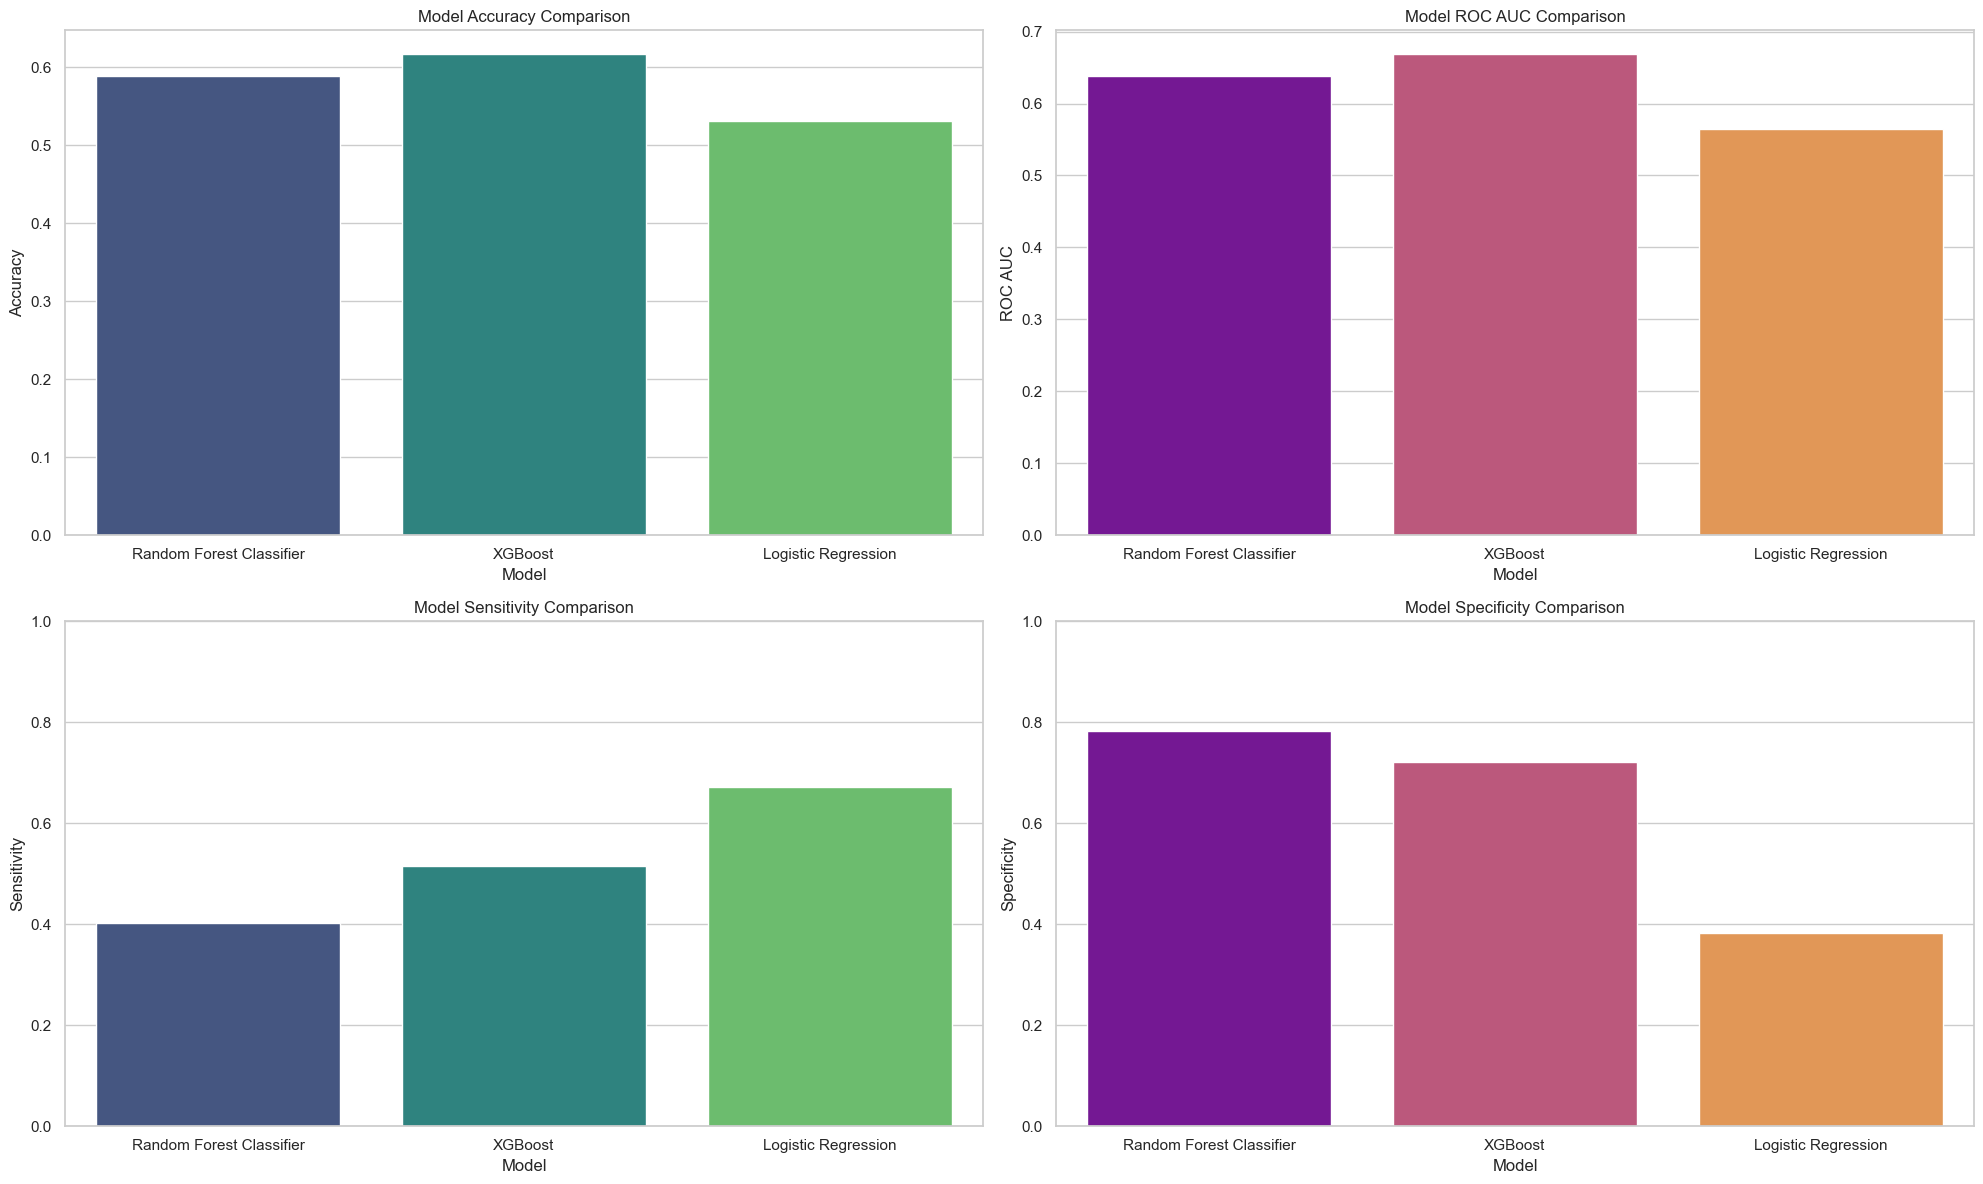

In [42]:
# Set the size of the overall figure
plt.figure(figsize=(20, 12))

# Subplot 1: Model Accuracy Comparison
plt.subplot(2, 2, 1)
sns.barplot(x='Model', y='Accuracy', data=df_scores, palette='viridis')
plt.title('Model Accuracy Comparison')

# Subplot 2: Model ROC AUC Comparison
plt.subplot(2, 2, 2)
sns.barplot(x='Model', y='ROC AUC', data=df_scores, palette='plasma')
plt.title('Model ROC AUC Comparison')

# Subplot 3: Model Sensitivity Comparison
plt.subplot(2, 2, 3)
sns.barplot(x='Model', y='Sensitivity', data=df_scores, palette='viridis')
plt.title('Model Sensitivity Comparison')
plt.ylim(0, 1)  # Adjust the y-axis limit if sensitivity values are between 0 and 1

# Subplot 4: Model Specificity Comparison
plt.subplot(2, 2, 4)
sns.barplot(x='Model', y='Specificity', data=df_scores, palette='plasma')
plt.title('Model Specificity Comparison')
plt.ylim(0, 1)  # Adjust the y-axis limit if specificity values are between 0 and 1

# Adjust layout to prevent overlap of titles and labels
plt.tight_layout()

# Show the plots
plt.show()

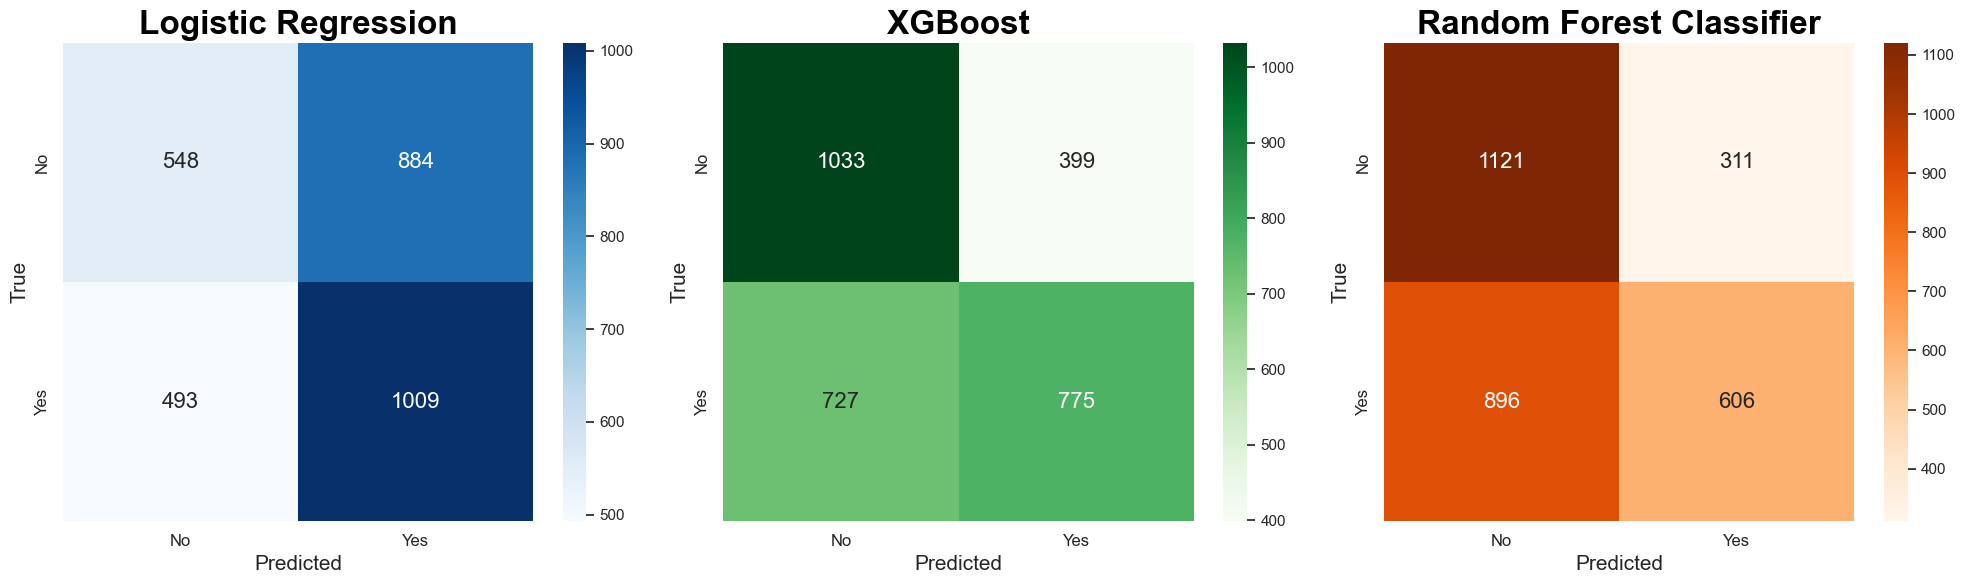

In [43]:
# Calculate confusion matrices
cm_logistic = confusion_matrix(y_test, y_pred_logreg)
cm_xgb = confusion_matrix(y_test, y_pred_xgb)
cm_lgb = confusion_matrix(y_test, y_pred_rf)

# Plot the confusion matrices side by side
plt.figure(figsize=(20, 6))

plt.subplot(131)
plt.title('Logistic Regression', fontweight='bold', color='black', fontsize='24', horizontalalignment='center')
chart_logistic = sns.heatmap(cm_logistic, annot=True, cmap="Blues", annot_kws={"size": 16}, fmt="g")
chart_logistic.set_xlabel('Predicted', fontsize=15)
chart_logistic.set_ylabel('True', fontsize=15)
chart_logistic.xaxis.set_ticklabels(['No', 'Yes'], fontsize=12)
chart_logistic.yaxis.set_ticklabels(['No', 'Yes'], fontsize=12, va='center')

plt.subplot(132)
plt.title('XGBoost', fontweight='bold', color='black', fontsize='24', horizontalalignment='center')
chart_xgb = sns.heatmap(cm_xgb, annot=True, cmap="Greens", annot_kws={"size": 16}, fmt="g")
chart_xgb.set_xlabel('Predicted', fontsize=15)
chart_xgb.set_ylabel('True', fontsize=15)
chart_xgb.xaxis.set_ticklabels(['No', 'Yes'], fontsize=12)
chart_xgb.yaxis.set_ticklabels(['No', 'Yes'], fontsize=12, va='center')

plt.subplot(133)
plt.title('Random Forest Classifier', fontweight='bold', color='black', fontsize='24', horizontalalignment='center')
chart_lgb = sns.heatmap(cm_lgb, annot=True, cmap="Oranges", annot_kws={"size": 16}, fmt="g")
chart_lgb.set_xlabel('Predicted', fontsize=15)
chart_lgb.set_ylabel('True', fontsize=15)
chart_lgb.xaxis.set_ticklabels(['No', 'Yes'], fontsize=12)
chart_lgb.yaxis.set_ticklabels(['No', 'Yes'], fontsize=12, va='center')

plt.tight_layout()
plt.show()

In [ ]:
# # Extract feature importances for Logistic Regression
# feature_importance_logistic = list(zip(X_train.columns, logreg_model.coef_[0]))
# feature_importance_logistic.sort(key=lambda x: abs(x[1]), reverse=True)
# top_features_logistic = feature_importance_logistic[:10]

# # Extract feature importances for XGBoost
# feature_importance_xgb = list(zip(X_train_.columns, best_xgb_model.feature_importances_))
# feature_importance_xgb.sort(key=lambda x: x[1], reverse=True)
# top_features_xgb = feature_importance_xgb[:10]

# # Extract feature importances for SVM
# feature_importance_lgb = list(zip(X_train.columns, best_lgb_model.coef_[0]))
# feature_importance_lgb.sort(key=lambda x: abs(x[1]), reverse=True)
# top_features_svm = feature_importance_svm[:10]

# # Plotting the top ten features for each model
# plt.figure(figsize=(18, 5))

# # Logistic Regression
# plt.subplot(131)
# sns.barplot(x=[f[0] for f in top_features_logistic], y=[f[1] for f in top_features_logistic], palette='Blues')
# plt.xticks(rotation=45, ha='right')
# plt.title('Logistic Regression Top Features')

# # XGBoost
# plt.subplot(132)
# sns.barplot(x=[f[0] for f in top_features_xgb], y=[f[1] for f in top_features_xgb], palette='Greens')
# plt.xticks(rotation=45, ha='right')
# plt.title('XGBoost Top Features')

# # LGB
# plt.bar([f[0] for f in top_features_svm], [f[1] for f in top_features_svm], color='orange')
# plt.xticks(rotation=45, ha='right')
# plt.title('SVM Top Features')



# plt.show()

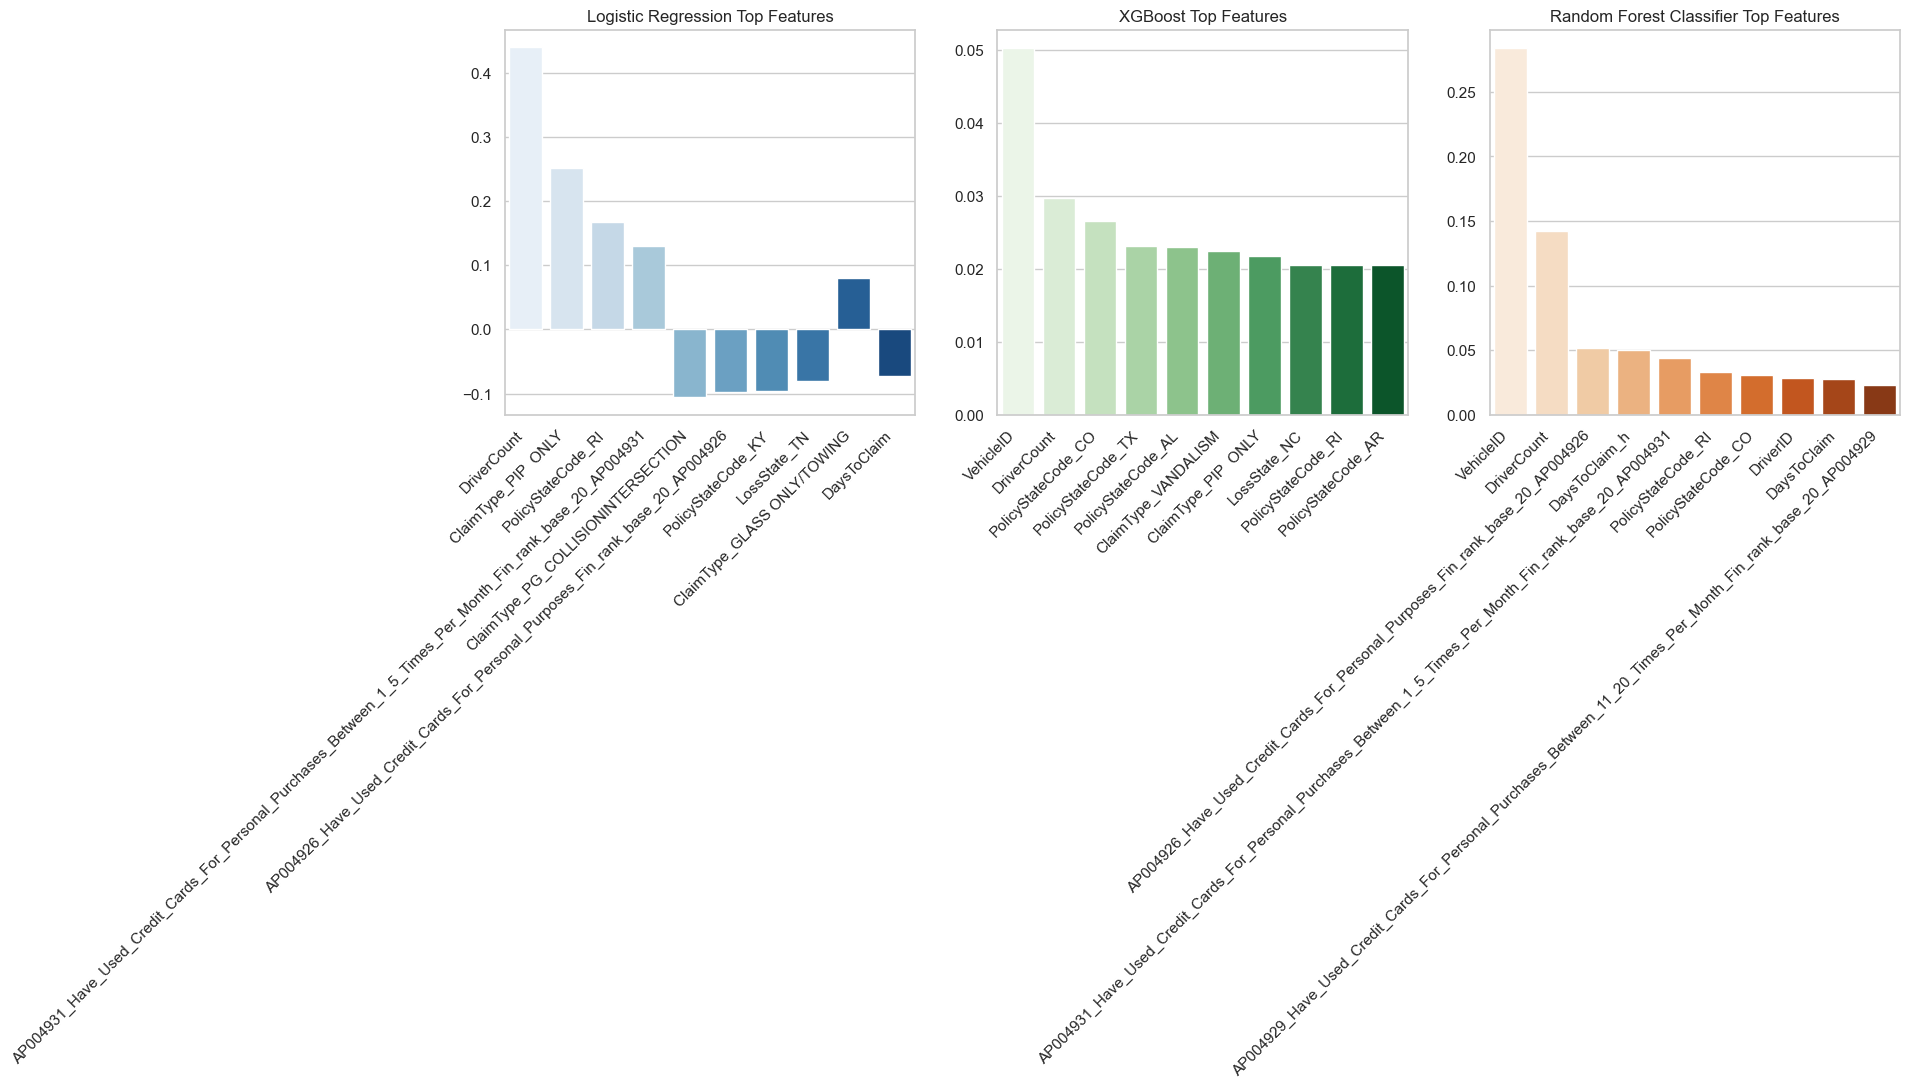

In [47]:
# Extract feature importances for Logistic Regression
feature_importance_logistic = list(zip(X_train.columns, best_logreg_model.coef_[0]))
feature_importance_logistic.sort(key=lambda x: abs(x[1]), reverse=True)
top_features_logistic = feature_importance_logistic[:10]

# Extract feature importances for XGBoost
feature_importance_xgb = list(zip(X_train.columns, best_xgb_model.feature_importances_))
feature_importance_xgb.sort(key=lambda x: x[1], reverse=True)
top_features_xgb = feature_importance_xgb[:10]

# Extract feature importances for LightGBM
feature_importance_rf = list(zip(X_train.columns, best_rf_model.feature_importances_))
feature_importance_rf.sort(key=lambda x: x[1], reverse=True)
top_features_rf = feature_importance_rf[:10]

# Plotting the top ten features for each model
plt.figure(figsize=(18, 5))

# Logistic Regression
plt.subplot(131)
sns.barplot(x=[f[0] for f in top_features_logistic], y=[f[1] for f in top_features_logistic], palette='Blues')
plt.xticks(rotation=45, ha='right')
plt.title('Logistic Regression Top Features')

# XGBoost
plt.subplot(132)
sns.barplot(x=[f[0] for f in top_features_xgb], y=[f[1] for f in top_features_xgb], palette='Greens')
plt.xticks(rotation=45, ha='right')
plt.title('XGBoost Top Features')

# LightGBM
plt.subplot(133)
sns.barplot(x=[f[0] for f in top_features_rf], y=[f[1] for f in top_features_rf], palette='Oranges')
plt.xticks(rotation=45, ha='right')
plt.title('Random Forest Classifier Top Features')

plt.show()

I really wanted to do a comparison between random forest classification, gradient boosting, and a support vector machine but I don't have the computational power. Instead, I was able to do a logistic regression model, a XGB (extreme gradient boosting) and LGB (light gradient boosting). The drastically help my computation time which was extremely helpful because I had to go back and keep removing predictors. The LGB and XGB are gradient boosting models, but they use different algorythms, so I felt better about including both of them. 